,age,d18O
0,9540,-34.24
1,9560,-34.24
3,9580,-35.02
5,9600,-35.02
7,9620,-34.55
...,...,...
11265,122200,-32.85
11267,122220,-32.66
11269,122240,-32.66
11271,122260,-32.51


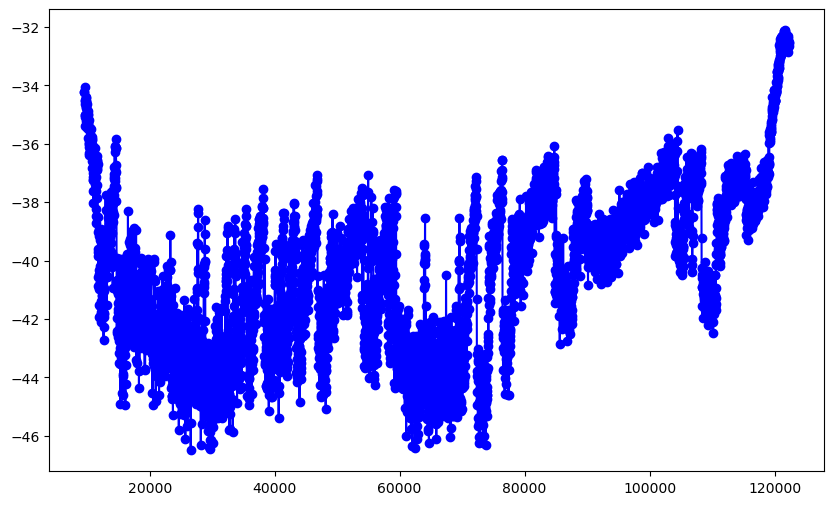

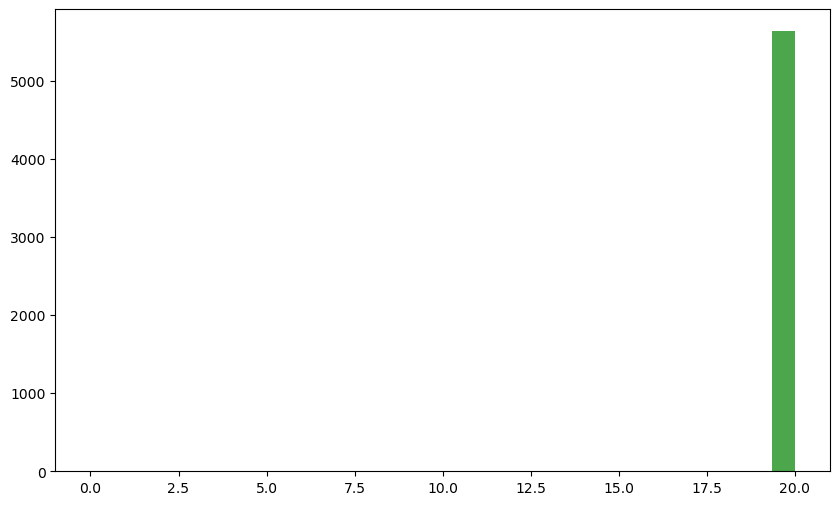

In [15]:
# read sheet  'NGRIP' of Ant_Gre.xlsx from D:\VScode\bipolar_seesaw_CCM\ice_core_data
import pandas as pd

df_ngrip= pd.read_excel(
    r'D:\VScode\bipolar_seesaw_CCM\ice_core_data\Ant_Gre.xlsx',
    sheet_name='NGRIP')

# remove the row with repeated values in the 'age' column
df_ngrip = df_ngrip.drop_duplicates(subset='age')

# plot the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(df_ngrip['age'], df_ngrip['d18O'], marker='o', linestyle='-', color='b')



age_diff = df_ngrip['age'].diff().fillna(0)
plt.figure(figsize=(10, 6))
# plot histogram of age differences
plt.hist(age_diff, bins=30, color='g', alpha=0.7)
df_ngrip

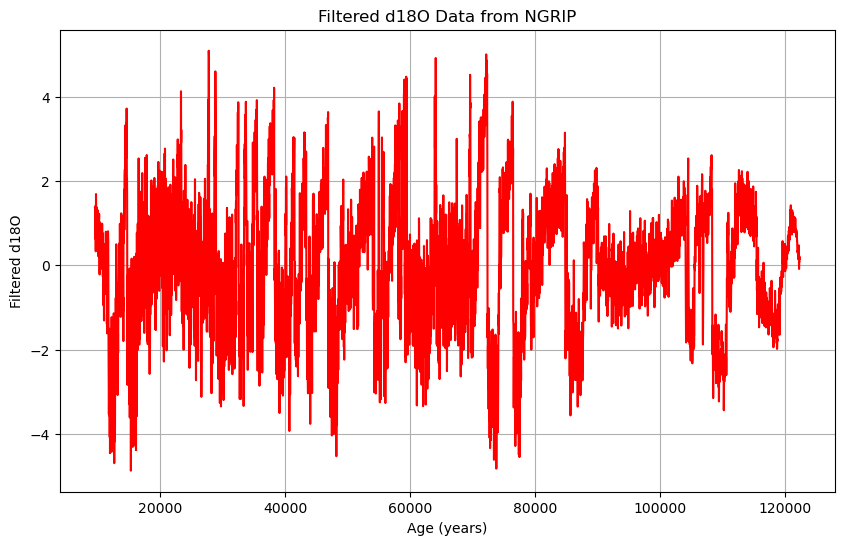

In [33]:
from scipy.signal import butter, filtfilt


dt=10


# 1) Design a 4th-order Butterworth high-pass filter
fs = 1 / dt      # sampling rate: 1 sample per 10 yr → 0.1 yr⁻¹
fc = 1 / 10000.0   # cutoff frequency: want to remove periods > 10 000 yr
Wn = fc / (fs / 2) # normalized cutoff (Nyquist = fs/2)

b, a = butter(N=4, Wn=Wn, btype='highpass')


filt_d18O = filtfilt(b, a, df_ngrip['d18O'].values)

df_ngrip['filt_d18O'] = filt_d18O

# create a new df
df_filtered = df_ngrip[['age', 'filt_d18O']].copy()

# plot the filtered data
plt.figure(figsize=(10, 6))
plt.plot(df_filtered['age'], df_filtered['filt_d18O'], marker='', linestyle='-', color='r')
plt.title('Filtered d18O Data from NGRIP')
plt.xlabel('Age (years)')
plt.ylabel('Filtered d18O')
plt.grid()
plt.show()


df_sq = df_filtered.copy()
# rename columns
df_sq.rename(columns={'age': 'age', 'filt_d18O': 'sq'}, inplace=True)

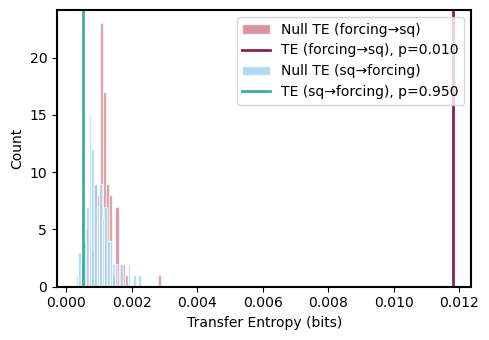

True


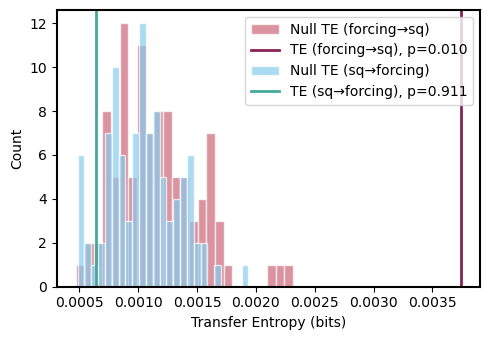

True


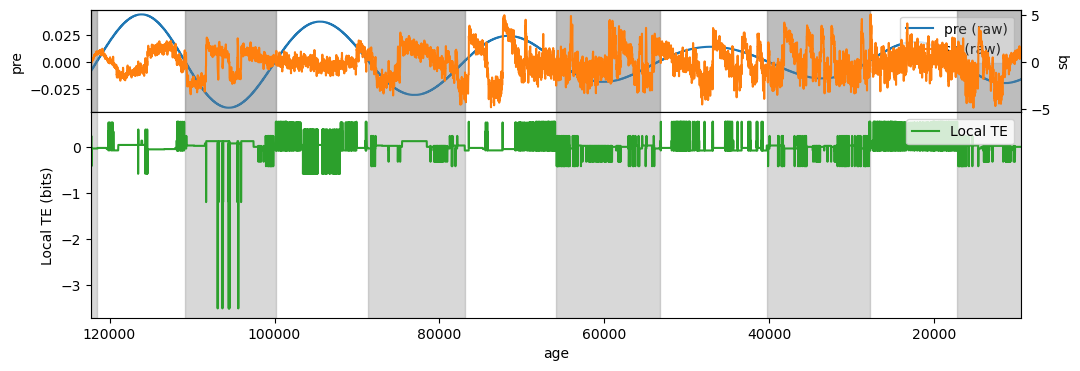

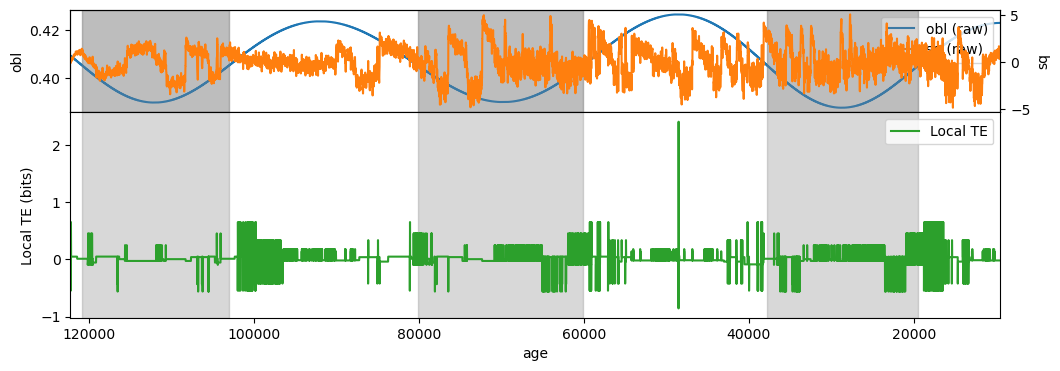

In [35]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values    # target (obliquity)
sq = df_sq_i['sq'].values    # target (residual)


# sq_method='hist',  # options: 'hist', 'quantile', 'kmeans'

result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)
result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='hist')
print(result)




# result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
# print(result)
# result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='quantile')
# print(result)


# result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
# print(result)
# result,fig=sa.transfer_entropy_surrogate_test(obl,sq, forcing_bins=6, sq_bins=2, sq_method='kmeans')
# print(result)


LTE = sa.local_TE(df_pre_i.copy(), df_sq_i.copy(),
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)




LTE = sa.local_TE(df_obl_i.copy(), df_sq_i.copy(),
                   forcing_column='obl',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=6,
                   nbins_target=2)

   pre_bin  sq_bin   p(flip)  baseline(flip)  contrib(flip)   p(stay)  \
0        0       0  0.051020        0.094159      -0.045104  0.948980   
1        0       1  0.980810        0.905405       0.113195  0.019190   
2        1       0  0.074104        0.094159      -0.025607  0.925896   
3        1       1  0.893424        0.905405      -0.017171  0.106576   
4        2       0  0.144295        0.094159       0.088864  0.855705   
5        2       1  0.884409        0.905405      -0.029938  0.115591   
6        3       0  0.071579        0.094159      -0.028314  0.928421   
7        3       1  0.901449        0.905405      -0.005695  0.098551   

   baseline(stay)  contrib(stay)   TE_orig  TE_surr_mean  TE_surr_sd  \
0        0.905841       0.063695  0.018592      0.000182    0.001277   
1        0.094595      -0.044164  0.069032      0.000133    0.000606   
2        0.905841       0.029252  0.003645      0.000332    0.000562   
3        0.094595       0.018337  0.001166      0.0006

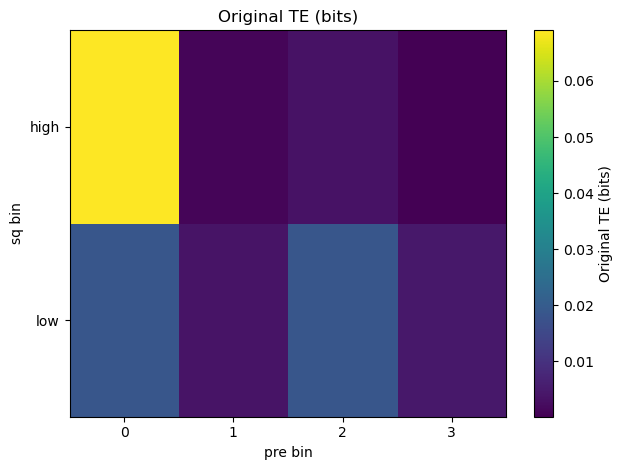

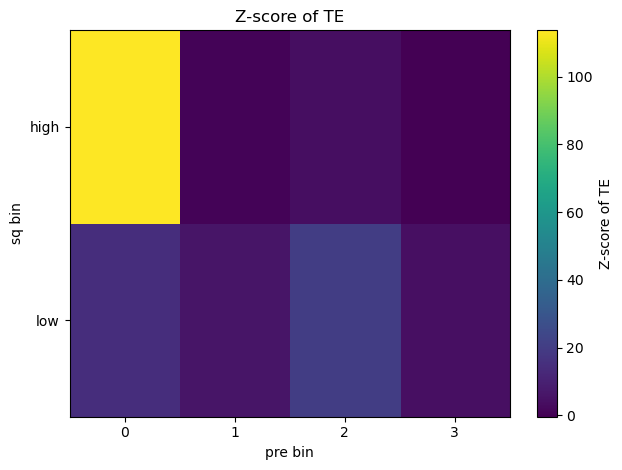

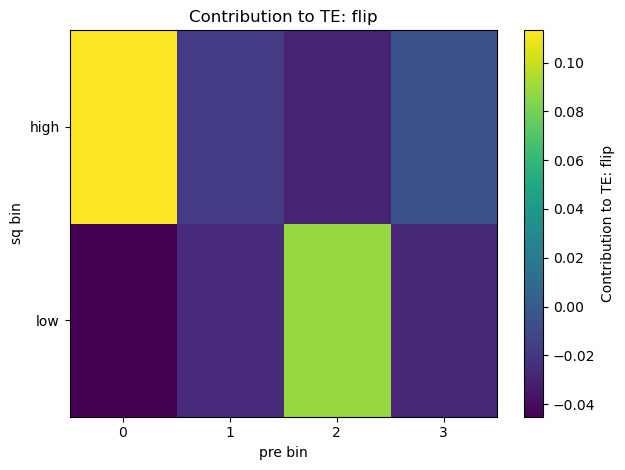

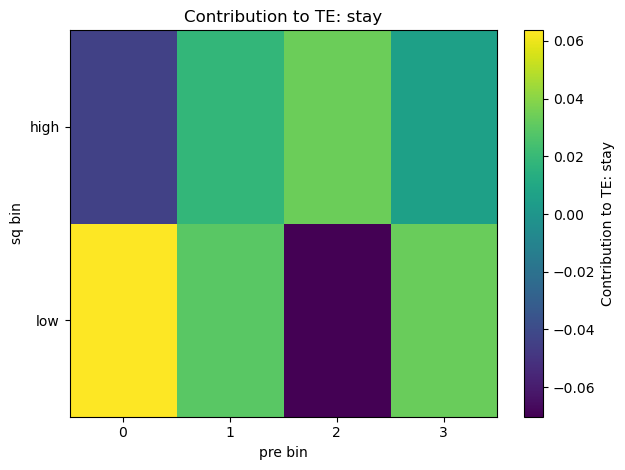

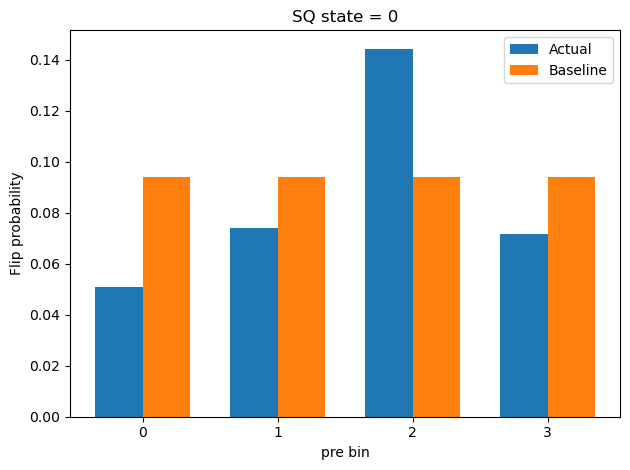

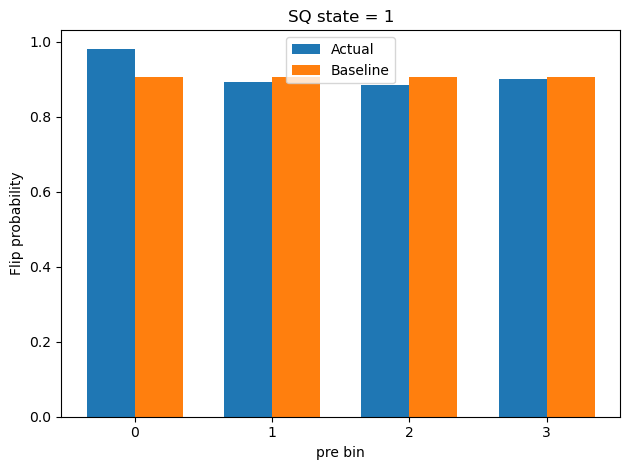

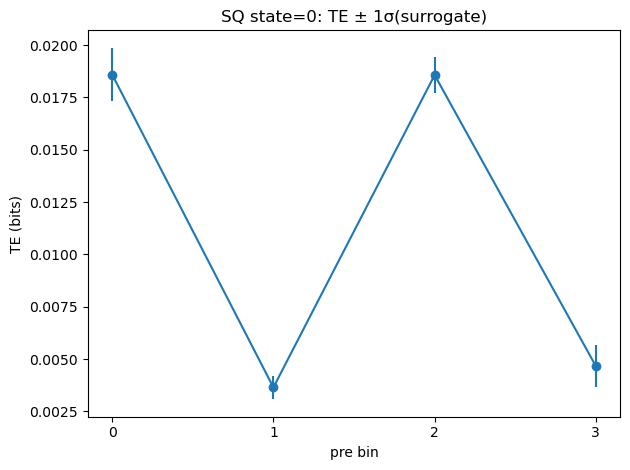

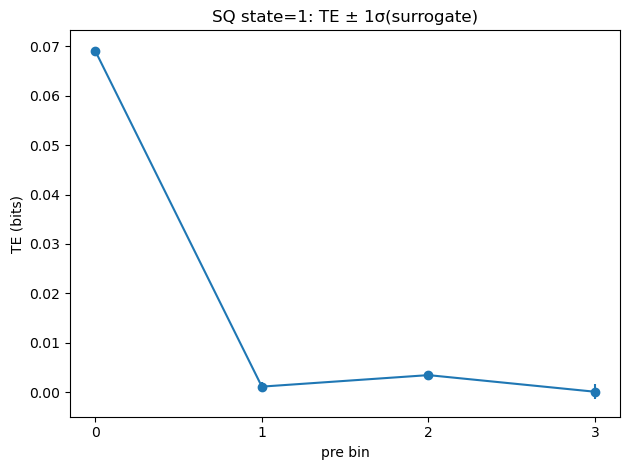

In [28]:
import numpy as np
from pyinform import transfer_entropy

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1

# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

nbins_pre = 4
nbins_sq  = 2

# Precompute the marginal baselines p(z | y=j) for j=0,1
p_z_given_y = {}
for j in (0,1):
    mask_y = (y_idx == j)
    counts = np.bincount(z_idx[mask_y], minlength=2)
    p_z_given_y[j] = counts / counts.sum()

# Compute the original TE heatmap once
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True).flatten()
te = local_te[1:] if local_te.shape[0]==N else local_te  # align

heatmap = np.full((nbins_pre, nbins_sq), np.nan)
for i in range(nbins_pre):
    for j in (0,1):
        mask = (x_idx==i)&(y_idx==j)
        if mask.any():
            heatmap[i,j] = te[mask].mean()

# Now loop over all cells
n_surr = 200
results = []

for i in range(nbins_pre):
    for j in (0,1):
        mask_ij = (x_idx==i)&(y_idx==j)
        if not mask_ij.any(): 
            continue

        # 1) Empirical p(z|i,j)
        counts_ij = np.bincount(z_idx[mask_ij], minlength=2)
        p_ij = counts_ij / counts_ij.sum()

        # 2) Contributions
        contribs = []
        for z in (0,1):
            pj = p_z_given_y[j][z]
            pij = p_ij[z]
            if pij>0 and pj>0:
                contribs.append(pij * np.log2(pij/pj))
            else:
                contribs.append(0.0)

        # 3) Surrogate TE distribution in this cell
        te_surr = np.zeros(n_surr)
        for k in range(n_surr):
            pre_s = np.random.permutation(pre_disc)
            local_s = transfer_entropy(pre_s, sq_disc, k=1, local=True).flatten()
            te_k  = local_s[1:] if local_s.shape[0]==N else local_s
            te_surr[k] = te_k[mask_ij].mean()

        mu_surr, sd_surr = te_surr.mean(), te_surr.std()
        te_orig = heatmap[i,j]

        results.append({
            'pre_bin': i,
            'sq_bin' : j,
            'p(stay)' : p_ij[0],
            'p(flip)' : p_ij[1],
            'baseline(stay)': p_z_given_y[j][0],
            'baseline(flip)': p_z_given_y[j][1],
            'contrib(stay)': contribs[0],
            'contrib(flip)': contribs[1],
            'TE_orig': te_orig,
            'TE_surr_mean': mu_surr,
            'TE_surr_sd': sd_surr,
            'z_score': (te_orig-mu_surr)/sd_surr
        })

# Print a nice table
import pandas as pd
df = pd.DataFrame(results)
print(df[['pre_bin','sq_bin',
          'p(flip)','baseline(flip)','contrib(flip)',
          'p(stay)','baseline(stay)','contrib(stay)',
          'TE_orig','TE_surr_mean','TE_surr_sd','z_score']])



import matplotlib.pyplot as plt
import numpy as np

# Assume `df` is the DataFrame with your results
# Pivot the data for heatmap plotting
pivot_te = df.pivot(index='sq_bin', columns='pre_bin', values='TE_orig').values
pivot_z = df.pivot(index='sq_bin', columns='pre_bin', values='z_score').values
pivot_flip = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(flip)').values
pivot_stay = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(stay)').values

# A helper to plot a heatmap
def plot_heatmap(data, title, ylabel='sq bin', xlabel='pre bin'):
    plt.figure()
    plt.imshow(data, origin='lower', aspect='auto',
               extent=[0, data.shape[1], 0, data.shape[0]])
    plt.colorbar(label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.yticks([0.5, 1.5], ['low', 'high'])
    plt.xticks(np.arange(0.5, data.shape[1] + 0.5), np.arange(data.shape[1]))
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_heatmap(pivot_te,    'Original TE (bits)')
plot_heatmap(pivot_z,     'Z-score of TE')
plot_heatmap(pivot_flip,  'Contribution to TE: flip')
plot_heatmap(pivot_stay,  'Contribution to TE: stay')




import numpy as np

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    x = sub['pre_bin']
    w = 0.35
    plt.figure()
    plt.bar(x - w/2, sub['p(flip)'], width=w)
    plt.bar(x + w/2, sub['baseline(flip)'], width=w)
    plt.xlabel('pre bin')
    plt.ylabel('Flip probability')
    plt.title(f'SQ state = {sq_state}')
    plt.legend(['Actual','Baseline'])
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    plt.figure()
    plt.errorbar(sub['pre_bin'], sub['TE_orig'],
                 yerr=sub['TE_surr_sd'], fmt='o-')
    plt.xlabel('pre bin')
    plt.ylabel('TE (bits)')
    plt.title(f'SQ state={sq_state}: TE ± 1σ(surrogate)')
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()


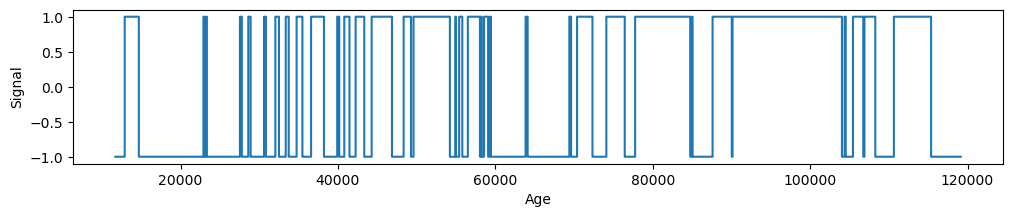

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Given ground truth intervals for the low phase (-1)
gs_data = {
    "start": [11703, 14692, 23020, 23340, 27780, 28900, 30840, 32500, 33740, 35480,
              38220, 40160, 41460, 43340, 46860, 49280, 54220, 55000, 55800, 58040,
              58280, 59080, 59440, 64100, 69620, 72340, 76440, 84760, 85060, 90040,
              104040,104520,106750,108280,115370],
    "end":   [12896, 22900, 23220, 27540, 28600, 30600, 32040, 33360, 34740, 36580,
              39900, 40800, 42240, 44280, 48340, 49600, 54900, 55400, 56500, 58160,
              58560, 59300, 63840, 69400, 70380, 74100, 77760, 84960, 87600, 90140,
              104380,105440,106900,110640,119140]
}

# Create an age vector (baseline resolution e.g. every 10 years)
ages = np.arange(11703, 119140, 1)

# Initialize signal at +1
signal = np.ones_like(ages)

# Flip to -1 during the specified low-phase intervals
for start, end in zip(gs_data["start"], gs_data["end"]):
    mask = (ages >= start) & (ages <= end)
    signal[mask] = -1

# Build a DataFrame for clarity
df_sq = pd.DataFrame({"age": ages, "sq": signal})

# Plot the irregular square wave
plt.figure(figsize=(12, 2))
plt.step(df_sq["age"], df_sq["sq"], where="post")
plt.xlabel("Age")
plt.ylabel("Signal")
# plt.title("Irregular Square Wave Signal")
plt.show()


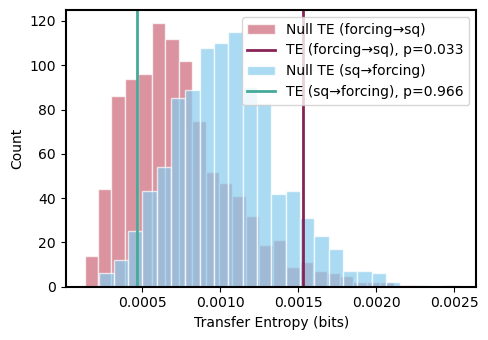

True


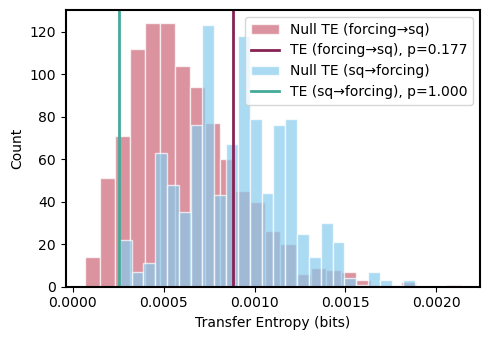

False


In [40]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
obl = df_obl_i['obl'].values      # forcing (obliquity)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=6, sq_bins=2, sq_method='hist', n_surr=1000)

# fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

print(result)

result, fig = sa.transfer_entropy_surrogate_test(obl, sq, k=1, forcing_bins=5, sq_bins=2, sq_method='hist', n_surr=1000)
print(result)

In [88]:
pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)

pre=pre[::-1]
sq=sq[::-1]


print("pre", pre.shape, "sq", sq.shape)

pre (5372,) sq (5372,)


In [86]:
sq

array([-1., -1., -1., ..., -1., -1., -1.])

Real TE: 0.0028
Null TE (mean ± std): 0.0013 ± 0.0007
Z-score: 2.37
P-value: 0.020


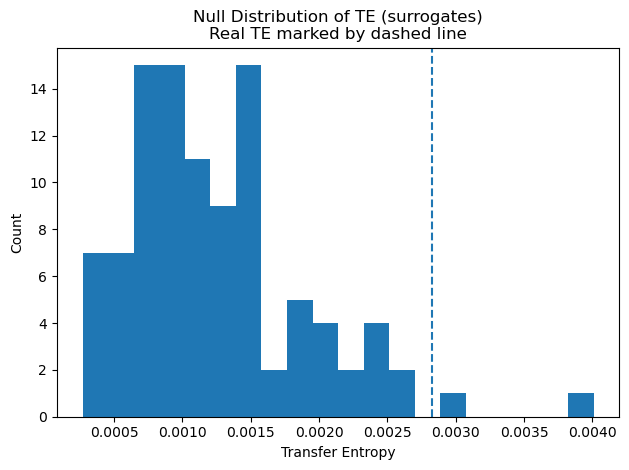

In [104]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform.transferentropy import transfer_entropy



# --- 1) Digitize `pre` into 4 bins and `sq` into 2 bins ---
edges_pre = np.histogram_bin_edges(pre, bins=4)
pre_disc = np.digitize(pre, edges_pre[1:-1])

edges_sq = np.histogram_bin_edges(sq, bins=2)
sq_disc = np.digitize(sq, edges_sq[1:-1])

# --- 2) Compute real transfer entropy (k=1) ---
real_te = transfer_entropy(pre_disc, sq_disc, k=1)

# --- 3) Recompute run‐lengths for surrogate generation ---
runs, lengths = [], []
cur_val, cur_len = sq[0], 1
for v in sq[1:]:
    if v == cur_val:
        cur_len += 1
    else:
        runs.append(cur_val)
        lengths.append(cur_len)
        cur_val, cur_len = v, 1
runs.append(cur_val)
lengths.append(cur_len)

lengths_stadial = [L for L, R in zip(lengths, runs) if R == -1]
lengths_inter   = [L for L, R in zip(lengths, runs) if R ==  1]

def generate_surrogate(runs, L_stad, L_int, N):
    seq = []
    for state in runs:
        L = np.random.choice(L_stad if state == -1 else L_int)
        seq.extend([state] * L)
        if len(seq) >= N:
            break
    seq = seq[:N]
    if len(seq) < N:
        seq.extend([seq[-1]] * (N - len(seq)))
    return np.array(seq)

# --- 4) Build null distribution of TE from surrogates ---
n_surrogates = 100
null_tes = []
for _ in range(n_surrogates):
    surr = generate_surrogate(runs, lengths_stadial, lengths_inter, len(sq))
    surr_disc = np.digitize(surr, edges_sq[1:-1])
    null_tes.append(transfer_entropy(pre_disc, surr_disc, k=1))
null_tes = np.array(null_tes)

# --- 5) Summary statistics ---
mean_null = null_tes.mean()
std_null = null_tes.std(ddof=1)
z_score = (real_te - mean_null) / std_null
p_value = (null_tes >= real_te).sum() / n_surrogates

print(f"Real TE: {real_te:.4f}")
print(f"Null TE (mean ± std): {mean_null:.4f} ± {std_null:.4f}")
print(f"Z-score: {z_score:.2f}")
print(f"P-value: {p_value:.3f}")

# --- 6) Plot null distribution with real TE marked ---
plt.figure()
plt.hist(null_tes, bins=20)
plt.axvline(real_te, linestyle='--')
plt.xlabel("Transfer Entropy")
plt.ylabel("Count")
plt.title("Null Distribution of TE (surrogates)\nReal TE marked by dashed line")
plt.tight_layout()
plt.show()


Real TE: 0.0028
Null TE (mean ± std): 0.0013 ± 0.0006
Z-score: 2.60
P-value: 0.020


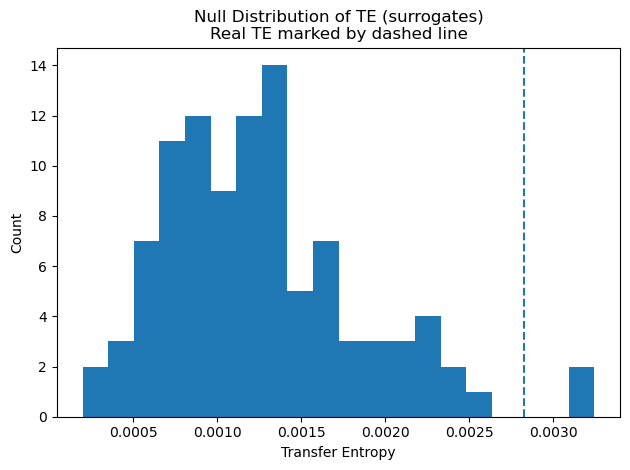

In [94]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# # --- 0) Ensure `sq` is defined (demo only) ---
# try:
#     sq
# except NameError:
#     np.random.seed(0)
#     sq = np.random.choice([-1, 1], size=5372)
#     print("Demo: using dummy 'sq' array")

# --- 0b) Ensure `pre` is defined (demo only) ---
try:
    pre
except NameError:
    np.random.seed(1)
    pre = np.random.randn(len(sq))
    print("Demo: using dummy 'pre' array")

# --- 1) Digitize `pre` into 4 bins and `sq` into 2 bins ---
edges_pre = np.histogram_bin_edges(pre, bins=4)
pre_disc = np.digitize(pre, edges_pre[1:-1])

edges_sq = np.histogram_bin_edges(sq, bins=2)
sq_disc = np.digitize(sq, edges_sq[1:-1])

# --- 2) Manual estimator for transfer entropy from 'pre' to 'sq' ---
def transfer_entropy_manual(source, target):
    x = target
    y = source
    N = len(x)
    counts_xyz = Counter()
    counts_xy = Counter()
    counts_xxn1 = Counter()
    counts_xn = Counter()
    # Build counts for (x_n, y_n, x_{n+1})
    for i in range(N - 1):
        xn = x[i]
        yn = y[i]
        xn1 = x[i + 1]
        counts_xyz[(xn, yn, xn1)] += 1
        counts_xy[(xn, yn)] += 1
        counts_xxn1[(xn, xn1)] += 1
        counts_xn[xn] += 1
    M = N - 1
    te = 0.0
    for (xn, yn, xn1), c in counts_xyz.items():
        p_xyz = c / M
        p_xn1_given_xy = c / counts_xy[(xn, yn)]
        p_xn1_given_x = counts_xxn1[(xn, xn1)] / counts_xn[(xn)]
        te += p_xyz * np.log2(p_xn1_given_xy / p_xn1_given_x)
    return te

# Compute real transfer entropy
real_te = transfer_entropy_manual(pre_disc, sq_disc)

# --- 3) Generate surrogate-based null distribution ---
# Recompute runs and lengths from `sq`
runs, lengths = [], []
cur_val, cur_len = sq[0], 1
for v in sq[1:]:
    if v == cur_val:
        cur_len += 1
    else:
        runs.append(cur_val)
        lengths.append(cur_len)
        cur_val, cur_len = v, 1
runs.append(cur_val)
lengths.append(cur_len)

lengths_stadial = [L for L, R in zip(lengths, runs) if R == -1]
lengths_inter   = [L for L, R in zip(lengths, runs) if R ==  1]

def generate_surrogate(runs, L_stad, L_int, N):
    seq = []
    for state in runs:
        L = np.random.choice(L_stad if state == -1 else L_int)
        seq.extend([state] * L)
        if len(seq) >= N:
            break
    seq = seq[:N]
    if len(seq) < N:
        seq.extend([seq[-1]] * (N - len(seq)))
    return np.array(seq)

n_surrogates = 100
null_tes = []
for _ in range(n_surrogates):
    surr = generate_surrogate(runs, lengths_stadial, lengths_inter, len(sq))
    surr_disc = np.digitize(surr, edges_sq[1:-1])
    null_tes.append(transfer_entropy_manual(pre_disc, surr_disc))
null_tes = np.array(null_tes)

# --- 4) Summary statistics ---
mean_null = null_tes.mean()
std_null = null_tes.std(ddof=1)
z_score = (real_te - mean_null) / std_null
p_value = (null_tes >= real_te).sum() / n_surrogates

print(f"Real TE: {real_te:.4f}")
print(f"Null TE (mean ± std): {mean_null:.4f} ± {std_null:.4f}")
print(f"Z-score: {z_score:.2f}")
print(f"P-value: {p_value:.3f}")

# --- 5) Plot null distribution with real TE marked ---
plt.figure()
plt.hist(null_tes, bins=20)
plt.axvline(real_te, linestyle='--')
plt.xlabel("Transfer Entropy")
plt.ylabel("Count")
plt.title("Null Distribution of TE (surrogates)\nReal TE marked by dashed line")
plt.tight_layout()
plt.show()


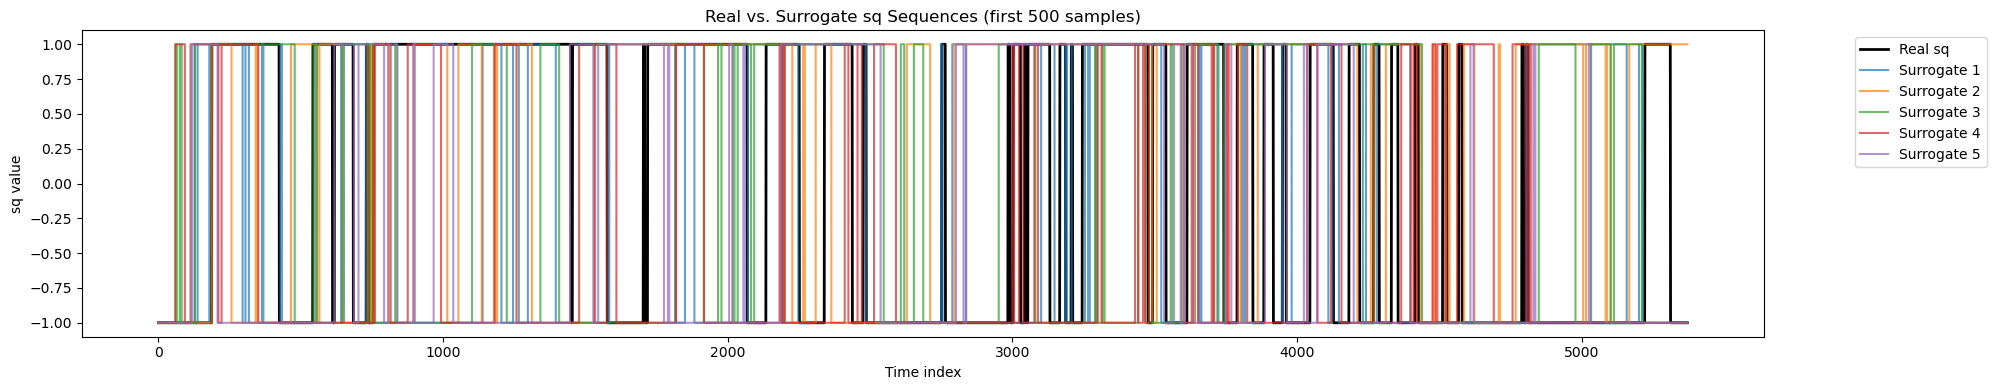

In [83]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1) Ensure `sq` is defined (demo only) ---
try:
    sq
except NameError:
    np.random.seed(0)
    sq = np.random.choice([-1, 1], size=5372)
    print("Demo: using dummy 'sq' array")

# --- 2) Extract empirical run‐length distributions ---
runs, lengths = [], []
cur_val, cur_len = sq[0], 1
for v in sq[1:]:
    if v == cur_val:
        cur_len += 1
    else:
        runs.append(cur_val)
        lengths.append(cur_len)
        cur_val, cur_len = v, 1
runs.append(cur_val)
lengths.append(cur_len)

lengths_stadial = [L for L, R in zip(lengths, runs) if R == -1]
lengths_inter  = [L for L, R in zip(lengths, runs) if R ==  1]

# --- 3) Surrogate generator function ---
def generate_surrogate(runs, L_stad, L_int, N):
    seq = []
    for state in runs:
        L = np.random.choice(L_stad if state == -1 else L_int)
        seq.extend([state] * L)
        if len(seq) >= N:
            break
    seq = seq[:N]
    if len(seq) < N:
        seq.extend([seq[-1]] * (N - len(seq)))
    return np.array(seq)

# --- 4) Generate a few surrogates for visual inspection ---
n_surrogates = 5
surrogates = [
    generate_surrogate(runs, lengths_stadial, lengths_inter, len(sq))
    for _ in range(n_surrogates)
]

# --- 5) Plot the real series vs. surrogates (first 500 samples) ---
plt.figure(figsize=(20, 4))
t = np.arange(len(sq))
plt.plot(t, sq, color='black', lw=2, label='Real sq')
for i, surr in enumerate(surrogates, 1):
    plt.step(t, surr, where='post', alpha=0.7, label=f'Surrogate {i}')
plt.xlabel('Time index')
plt.ylabel('sq value')
plt.title('Real vs. Surrogate sq Sequences (first 500 samples)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [69]:
sq = df_sq_i['sq'].values
sq.shape

(5372,)

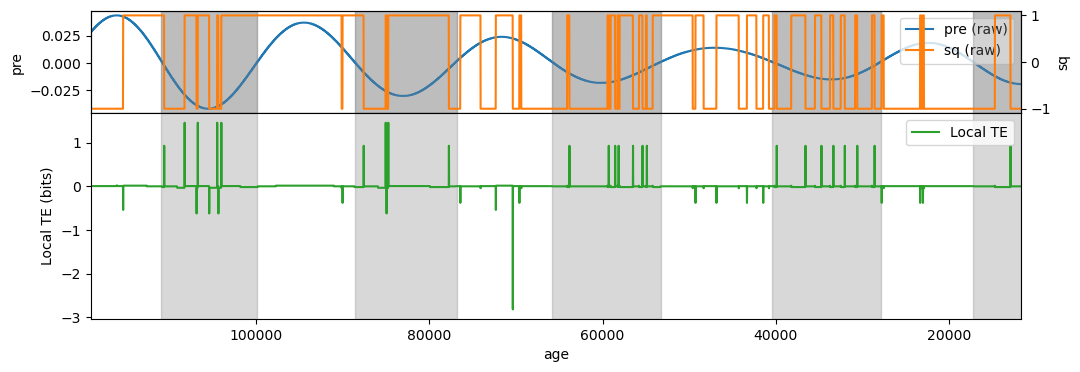

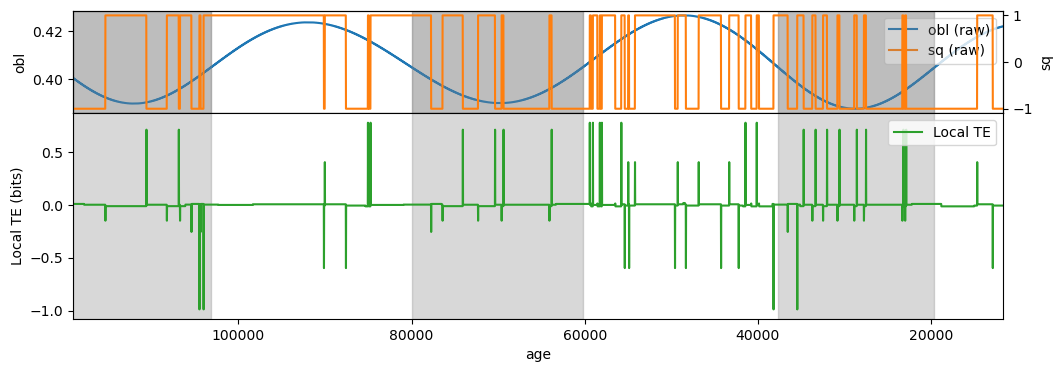

In [3]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

LTE = sa.local_TE(df_pre_i, df_sq_i,
                   forcing_column='pre',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

LTE = sa.local_TE(df_obl_i, df_sq_i,
                   forcing_column='obl',
                   target_column='sq',
                   time_column='age',
                   nbins_pre=4,
                   nbins_target=2)

In [61]:
# pre_ori = df_pre_i['pre'].values      # source (precession)
# sq_ori = df_sq_i['sq'].values    # target (residual)

# sq=sq_ori[::-1]
# pre=pre_ori[::-1]

# print(sq.shape)
# print(pre.shape)



# import numpy as np
# import matplotlib.pyplot as plt


# # 1. build past / current arrays
# x = pre
# y = sq
# x_past = x[:-1]
# y_past = y[:-1]
# y_curr = y[1:]

# # 2. choose separate number of bins
# n_bins_x = 5   # for pre
# n_bins_y = 2   # for sq (and y_curr)

# # 3. compute quantile edges separately
# x_edges = np.quantile(x_past, np.linspace(0, 1, n_bins_x + 1))
# y_edges = np.quantile(y_past, np.linspace(0, 1, n_bins_y + 1))
# z_edges = np.quantile(y_curr, np.linspace(0, 1, n_bins_y + 1))

# # 4. digitize into bin‐indices 0…n_bins-1
# x_idx = np.digitize(x_past, bins=x_edges[1:-1])
# y_idx = np.digitize(y_past, bins=y_edges[1:-1])
# z_idx = np.digitize(y_curr,  bins=z_edges[1:-1])

# # 5. build counts
# counts_xyz = np.zeros((n_bins_x, n_bins_y, n_bins_y), float)
# counts_yz  = np.zeros((n_bins_y,   n_bins_y),   float)

# for xi, yi, zi in zip(x_idx, y_idx, z_idx):
#     counts_xyz[xi, yi, zi] += 1
#     counts_yz[yi, zi]      += 1

# # 6. convert to probabilities with tiny smoothing
# eps = 1e-8
# p_xyz = (counts_xyz + eps) / (counts_xyz + eps).sum()
# p_yz  = (counts_yz  + eps) / (counts_yz  + eps).sum()

# # 7. conditional distributions p(z|x,y) and p(z|y)
# p_z_xy = p_xyz / (p_xyz.sum(axis=2, keepdims=True) + eps)
# p_z_y  = p_yz  / (p_yz.sum(axis=1, keepdims=True)  + eps)

# # 8. compute local TE for each time point
# local_te = np.log(
#     p_z_xy[x_idx, y_idx, z_idx] /
#     p_z_y[y_idx, z_idx]
# )

# # 9. average TE in each (x_bin, y_bin) cell → heatmap
# heatmap = np.full((n_bins_x, n_bins_y), np.nan)
# for i in range(n_bins_x):
#     for j in range(n_bins_y):
#         mask = (x_idx == i) & (y_idx == j)
#         if mask.any():
#             heatmap[i, j] = local_te[mask].mean()

# # 10. plot
# plt.figure(figsize=(6,3))
# plt.imshow(heatmap.T, origin='lower', aspect='auto')
# plt.colorbar(label='Average Local TE')
# plt.xlabel('Past Pre amplitude bin (4 quantiles)')
# plt.ylabel('Past Sq amplitude bin (2 quantiles)')
# plt.title('State‐Space / Amplitude‐Conditioned TE\n(4×2 bins)')
# plt.tight_layout()
# plt.show()



# Local TE
$$
t_{X \to Y}(n+1)
=
\log
\frac{
  p\!\bigl(y_{n+1}\mid y_n^{(K)},\,x_n^{(L)}\bigr)
}{
  p\!\bigl(y_{n+1}\mid y_n^{(K)}\bigr)
}\,.
$$



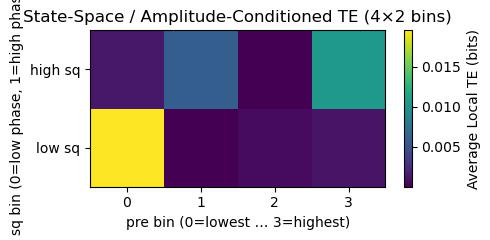

Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):
[[ 169  496]
 [1225  762]
 [1006  914]
 [ 230  569]]

Marginal counts for pre_bin (0..3):
  pre_bin 0: 665
  pre_bin 1: 1987
  pre_bin 2: 1920
  pre_bin 3: 799

Marginal counts for sq_bin (0=low, 1=high):
  sq low (0):  2630
  sq high (1): 2741
Cell (pre=low, sq=low): 169 samples
   P(sq_next=0 | 0,0) = 0.964
   P(sq_next=1 | 0,0) = 0.036

Cell (pre=high, sq=low): 230 samples
   P(sq_next=0 | 3,0) = 0.991
   P(sq_next=1 | 3,0) = 0.009

Cell (pre=low, sq=high): 496 samples
   P(sq_next=0 | 0,1) = 0.008
   P(sq_next=1 | 0,1) = 0.992

Cell (pre=high, sq=high): 569 samples
   P(sq_next=0 | 3,1) = 0.002
   P(sq_next=1 | 3,1) = 0.998


In [5]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy

# --- load & discretize (as before) ---
pre_ori = df_pre_i['pre'].values
sq_ori  = df_sq_i['sq'].values
sq  = sq_ori[::-1]
pre = pre_ori[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()

nbins_pre = 4
nbins_sq  = 2

# Clip into [0, nbins-1]
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, nbins_sq -1)

# 1) Joint counts for (pre_bin, sq_bin)
joint_counts = np.zeros((nbins_pre, nbins_sq), dtype=int)
for xi, yi in zip(x_idx_clipped, y_idx_clipped):
    joint_counts[xi, yi] += 1

print("Joint counts (rows = pre_bin 0..3; cols = sq_bin 0..1):")
print(joint_counts)

# 2) Marginal counts for pre alone
pre_counts = np.bincount(x_idx_clipped, minlength=nbins_pre)
print("\nMarginal counts for pre_bin (0..3):")
for i, c in enumerate(pre_counts):
    print(f"  pre_bin {i}: {c}")

# 3) Marginal counts for sq alone
sq_counts = np.bincount(y_idx_clipped, minlength=nbins_sq)
print("\nMarginal counts for sq_bin (0=low, 1=high):")
print(f"  sq low (0):  {sq_counts[0]}")
print(f"  sq high (1): {sq_counts[1]}")



# Clip indices just in case
x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1

# Function to compute P(z | x=i, y=j)
def transition_probs(i, j):
    mask = (x_idx_clipped == i) & (y_idx_clipped == j)
    counts = np.bincount(z_idx[mask], minlength=2)
    total = counts.sum()
    return counts / total, total

# Get for the “low-pre & low-sq” cell (i=0, j=0)
probs_00, total_00 = transition_probs(0, 0)
print(f"Cell (pre=low, sq=low): {total_00} samples")
print(f"   P(sq_next=0 | 0,0) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,0) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 0)
print(f"\nCell (pre=high, sq=low): {total_30} samples")
print(f"   P(sq_next=0 | 3,0) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,0) = {probs_30[1]:.3f}")



probs_00, total_00 = transition_probs(0, 1)
print(f"\nCell (pre=low, sq=high): {total_00} samples")
print(f"   P(sq_next=0 | 0,1) = {probs_00[0]:.3f}")
print(f"   P(sq_next=1 | 0,1) = {probs_00[1]:.3f}")

# And for comparison, say “pre=high, sq=low” (i=3, j=0)
probs_30, total_30 = transition_probs(3, 1)
print(f"\nCell (pre=high, sq=high): {total_30} samples")
print(f"   P(sq_next=0 | 3,1) = {probs_30[0]:.3f}")
print(f"   P(sq_next=1 | 3,1) = {probs_30[1]:.3f}")

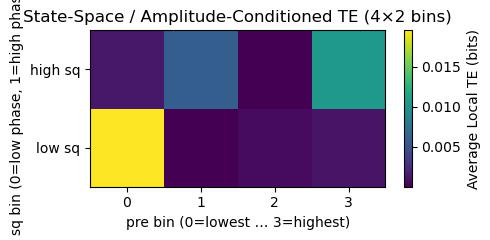

z=0: p=0.964, baseline=0.987, contrib=-0.0322 bits
z=1: p=0.036, baseline=0.013, contrib=0.0517 bits
Surrogate TE₀₀:   0.0026 ± 0.0064
Original TE₀₀:    0.0196


In [9]:

import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy





pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1



# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

# Decide how to slice te_arr so it lines up with x_idx/y_idx
if te_arr.shape[0] == N:
    # TE[0] corresponds to t=0 → drop it
    te = te_arr[1:]
elif te_arr.shape[0] == N-1:
    # Already aligned
    te = te_arr
else:
    raise ValueError(
        f"Unexpected local_te length: {te_arr.shape[0]} (expected {N} or {N-1})"
    )

# sanity check
assert te.shape[0] == x_idx.shape[0] == y_idx.shape[0], (
    f"Shapes mismatch: te {te.shape}, x_idx {x_idx.shape}, y_idx {y_idx.shape}"
)
# --- 3) Build the heatmap ---
nbins_pre = 4
heatmap = np.full((nbins_pre, 2), np.nan)
for i in range(nbins_pre):
    for j in (0, 1):
        mask = (x_idx == i) & (y_idx == j)
        if mask.any():
            heatmap[i, j] = te[mask].mean()

# --- 4) Plot ---
plt.figure(figsize=(5,2.5))
plt.imshow(heatmap.T, origin='lower', aspect='auto',
           extent=[0, nbins_pre, 0, 2])
plt.colorbar(label='Average Local TE (bits)')
plt.xlabel('pre bin (0=lowest … 3=highest)')
plt.ylabel('sq bin (0=low phase, 1=high phase)')
plt.title('State‐Space / Amplitude‐Conditioned TE (4×2 bins)')
plt.yticks([0.5,1.5], ['low sq','high sq'])
plt.xticks(np.arange(0.5, nbins_pre+0.5), np.arange(nbins_pre))
plt.tight_layout()
plt.show()



x_idx_clipped = np.clip(x_idx, 0, nbins_pre-1)
y_idx_clipped = np.clip(y_idx, 0, 1)
z_idx = sq_disc[1:]   # future state of sq, 0 or 1
# 1) global marginal p(z | y=0)
mask_y0 = (y_idx == 0)
counts_y0 = np.bincount(z_idx[mask_y0], minlength=2)
p_z_given_y0 = counts_y0 / counts_y0.sum()

# 2) conditional p(z | x=0, y=0)
mask_00 = (x_idx == 0) & (y_idx == 0)
counts_00 = np.bincount(z_idx[mask_00], minlength=2)
p_z_given_00 = counts_00 / counts_00.sum()

# 3) contribution of each outcome
for z in (0,1):
    contrib = p_z_given_00[z] * np.log2(p_z_given_00[z] / p_z_given_y0[z])
    print(f"z={z}: p={p_z_given_00[z]:.3f}, "
          f"baseline={p_z_given_y0[z]:.3f}, contrib={contrib:.4f} bits")
    



import numpy as np
from pyinform import transfer_entropy

n_surr = 100
te00_surr = np.zeros(n_surr)

for i in range(n_surr):
    # 1) Permute source
    pre_surr = np.random.permutation(pre_disc)

    # 2) Compute local TE
    local_te_s = transfer_entropy(pre_surr, sq_disc, k=1, local=True)
    arr = local_te_s.flatten()

    # 3) Align to length N-1
    if arr.shape[0] == N:
        te_s = arr[1:]
    elif arr.shape[0] == N-1:
        te_s = arr
    else:
        raise ValueError(
            f"Unexpected local_te length: {arr.shape[0]}"
        )

    # 4) Extract the (pre=0, sq=0) cell mean
    mask = (x_idx == 0) & (y_idx == 0)
    te00_surr[i] = te_s[mask].mean()

# Finally compare
print("Surrogate TE₀₀:  ",
      f"{te00_surr.mean():.4f} ± {te00_surr.std():.4f}")
print("Original TE₀₀:   ", f"{heatmap[0,0]:.4f}")







   pre_bin  sq_bin   p(flip)  baseline(flip)  contrib(flip)   p(stay)  \
0        0       0  0.035503        0.012928       0.051744  0.964497   
1        0       1  0.991935        0.987596       0.006275  0.008065   
2        1       0  0.013061        0.012928       0.000194  0.986939   
3        1       1  0.976378        0.987596      -0.016092  0.023622   
4        2       0  0.009940        0.012928      -0.003768  0.990060   
5        2       1  0.987965        0.987596       0.000533  0.012035   
6        3       0  0.008889        0.012928      -0.004804  0.991111   
7        3       1  0.998243        0.987596       0.015443  0.001757   

   baseline(stay)  contrib(stay)   TE_orig  TE_surr_mean  TE_surr_sd  \
0        0.987072      -0.032194  0.019551      0.001931    0.005420   
1        0.012404      -0.005009  0.001265      0.000399    0.001549   
2        0.987072      -0.000193  0.000001      0.000937    0.001160   
3        0.012404       0.021952  0.005860      0.0016

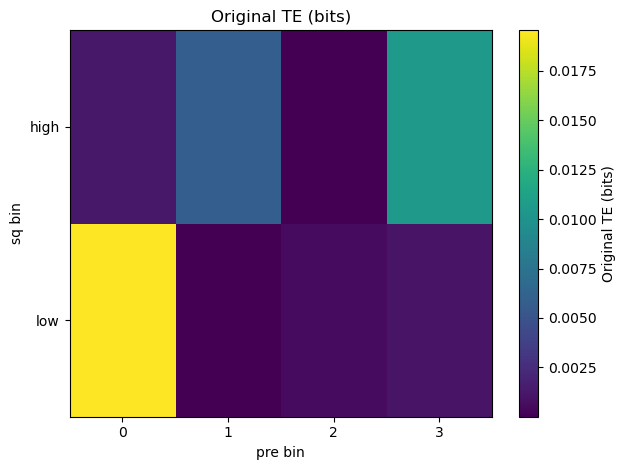

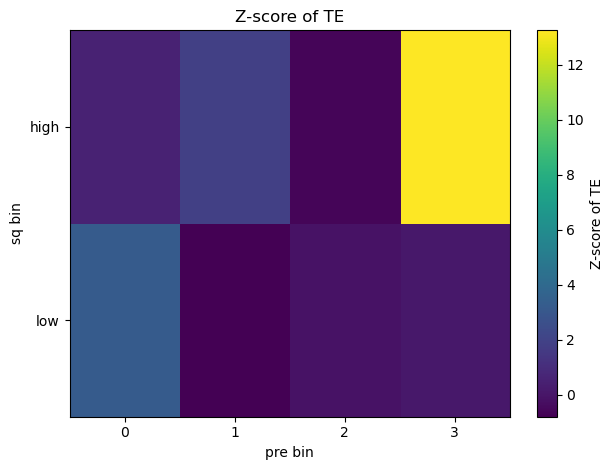

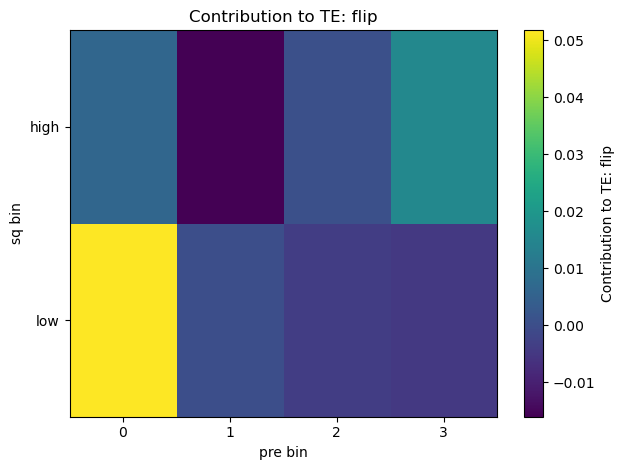

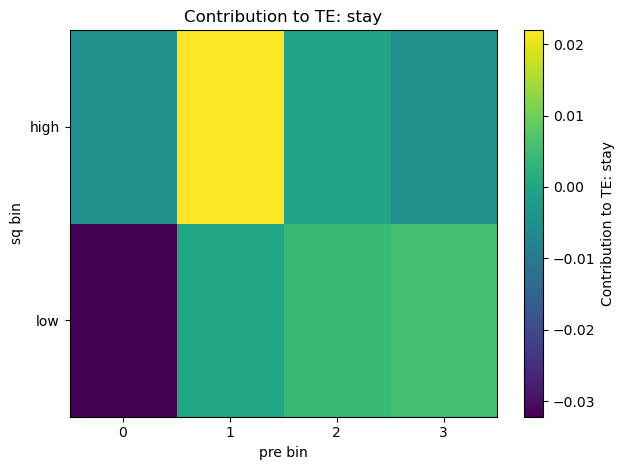

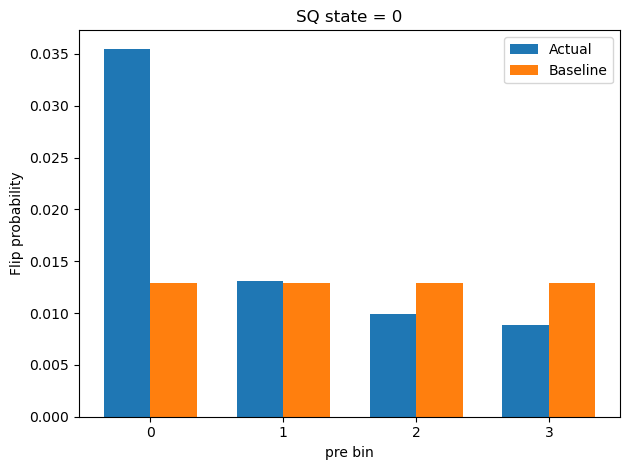

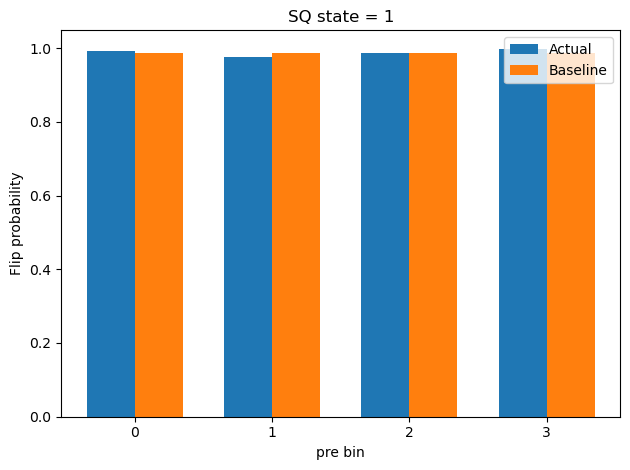

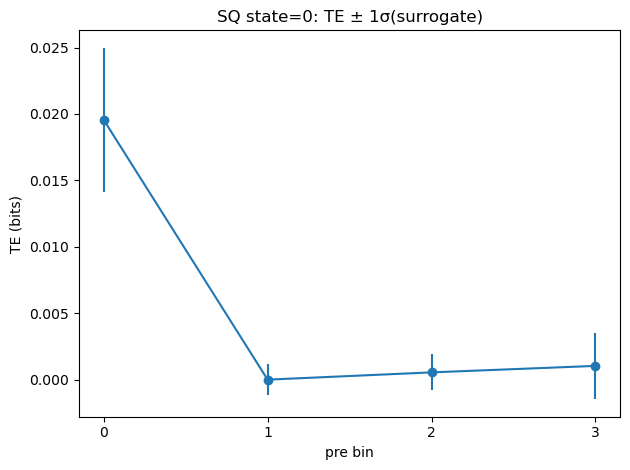

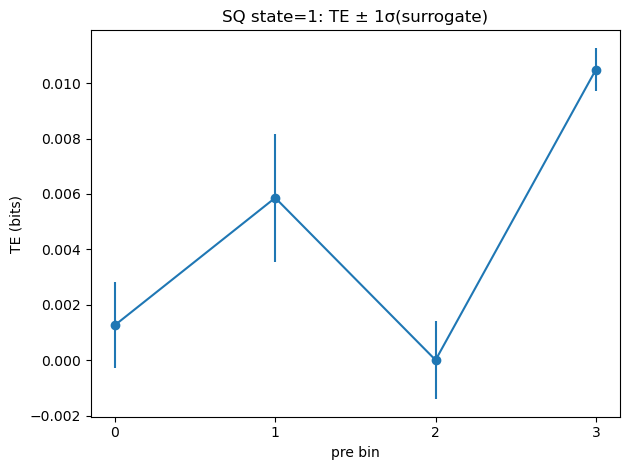

In [11]:
import numpy as np
from pyinform import transfer_entropy

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)
sq  = sq[::-1]
pre = pre[::-1]

# Pre: 4 bins
nbins_pre = 4
bins_pre  = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc  = np.digitize(pre, bins_pre) - 1      # 0..3

# SQ: 2 bins (0/1)
sq_disc   = (sq > 0).astype(int)               # 0..1

# --- 2) Compute local TE (k=1) ---
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 2a) Flatten and auto-align ---
# Get a 1D array
te_arr = local_te.flatten()

# Number of original samples
N = pre_disc.shape[0]

# Past‐state indices each have length N-1
x_idx = pre_disc[:-1]
y_idx = sq_disc[:-1]

nbins_pre = 4
nbins_sq  = 2

# Precompute the marginal baselines p(z | y=j) for j=0,1
p_z_given_y = {}
for j in (0,1):
    mask_y = (y_idx == j)
    counts = np.bincount(z_idx[mask_y], minlength=2)
    p_z_given_y[j] = counts / counts.sum()

# Compute the original TE heatmap once
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True).flatten()
te = local_te[1:] if local_te.shape[0]==N else local_te  # align

heatmap = np.full((nbins_pre, nbins_sq), np.nan)
for i in range(nbins_pre):
    for j in (0,1):
        mask = (x_idx==i)&(y_idx==j)
        if mask.any():
            heatmap[i,j] = te[mask].mean()

# Now loop over all cells
n_surr = 200
results = []

for i in range(nbins_pre):
    for j in (0,1):
        mask_ij = (x_idx==i)&(y_idx==j)
        if not mask_ij.any(): 
            continue

        # 1) Empirical p(z|i,j)
        counts_ij = np.bincount(z_idx[mask_ij], minlength=2)
        p_ij = counts_ij / counts_ij.sum()

        # 2) Contributions
        contribs = []
        for z in (0,1):
            pj = p_z_given_y[j][z]
            pij = p_ij[z]
            if pij>0 and pj>0:
                contribs.append(pij * np.log2(pij/pj))
            else:
                contribs.append(0.0)

        # 3) Surrogate TE distribution in this cell
        te_surr = np.zeros(n_surr)
        for k in range(n_surr):
            pre_s = np.random.permutation(pre_disc)
            local_s = transfer_entropy(pre_s, sq_disc, k=1, local=True).flatten()
            te_k  = local_s[1:] if local_s.shape[0]==N else local_s
            te_surr[k] = te_k[mask_ij].mean()

        mu_surr, sd_surr = te_surr.mean(), te_surr.std()
        te_orig = heatmap[i,j]

        results.append({
            'pre_bin': i,
            'sq_bin' : j,
            'p(stay)' : p_ij[0],
            'p(flip)' : p_ij[1],
            'baseline(stay)': p_z_given_y[j][0],
            'baseline(flip)': p_z_given_y[j][1],
            'contrib(stay)': contribs[0],
            'contrib(flip)': contribs[1],
            'TE_orig': te_orig,
            'TE_surr_mean': mu_surr,
            'TE_surr_sd': sd_surr,
            'z_score': (te_orig-mu_surr)/sd_surr
        })

# Print a nice table
import pandas as pd
df = pd.DataFrame(results)
print(df[['pre_bin','sq_bin',
          'p(flip)','baseline(flip)','contrib(flip)',
          'p(stay)','baseline(stay)','contrib(stay)',
          'TE_orig','TE_surr_mean','TE_surr_sd','z_score']])



import matplotlib.pyplot as plt
import numpy as np

# Assume `df` is the DataFrame with your results
# Pivot the data for heatmap plotting
pivot_te = df.pivot(index='sq_bin', columns='pre_bin', values='TE_orig').values
pivot_z = df.pivot(index='sq_bin', columns='pre_bin', values='z_score').values
pivot_flip = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(flip)').values
pivot_stay = df.pivot(index='sq_bin', columns='pre_bin', values='contrib(stay)').values

# A helper to plot a heatmap
def plot_heatmap(data, title, ylabel='sq bin', xlabel='pre bin'):
    plt.figure()
    plt.imshow(data, origin='lower', aspect='auto',
               extent=[0, data.shape[1], 0, data.shape[0]])
    plt.colorbar(label=title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.yticks([0.5, 1.5], ['low', 'high'])
    plt.xticks(np.arange(0.5, data.shape[1] + 0.5), np.arange(data.shape[1]))
    plt.tight_layout()
    plt.show()

# Plot each metric
plot_heatmap(pivot_te,    'Original TE (bits)')
plot_heatmap(pivot_z,     'Z-score of TE')
plot_heatmap(pivot_flip,  'Contribution to TE: flip')
plot_heatmap(pivot_stay,  'Contribution to TE: stay')




import numpy as np

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    x = sub['pre_bin']
    w = 0.35
    plt.figure()
    plt.bar(x - w/2, sub['p(flip)'], width=w)
    plt.bar(x + w/2, sub['baseline(flip)'], width=w)
    plt.xlabel('pre bin')
    plt.ylabel('Flip probability')
    plt.title(f'SQ state = {sq_state}')
    plt.legend(['Actual','Baseline'])
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()

for sq_state in (0,1):
    sub = df[df['sq_bin']==sq_state]
    plt.figure()
    plt.errorbar(sub['pre_bin'], sub['TE_orig'],
                 yerr=sub['TE_surr_sd'], fmt='o-')
    plt.xlabel('pre bin')
    plt.ylabel('TE (bits)')
    plt.title(f'SQ state={sq_state}: TE ± 1σ(surrogate)')
    plt.xticks([0,1,2,3])
    plt.tight_layout()
    plt.show()


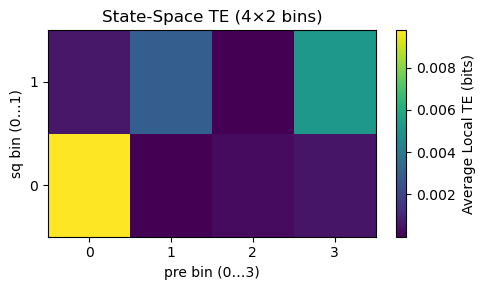

Joint counts (rows=pre_bin, cols=sq_bin):
[[ 337  993]
 [2453 1521]
 [2013 1827]
 [ 461 1138]]

Marginal counts for pre_bins:
  pre_bin 0: 1330
  pre_bin 1: 3974
  pre_bin 2: 3840
  pre_bin 3: 1599

Marginal counts for sq_bins:
  sq low (0): 5264
  sq high (1): 5479

Cell (pre=low, sq=low): 337 samples
  P(sq_next=0)=0.982, P(sq_next=1)=0.018

Cell (pre=high, sq=low): 461 samples
  P(sq_next=0)=0.996, P(sq_next=1)=0.004


In [60]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

results = sa.analyze_state_space_TE(
    df_pre_i,
    df_sq_i,
    forcing_column='pre',
    target_column='sq',
    nbins_pre=4,
    nbins_sq=2
)


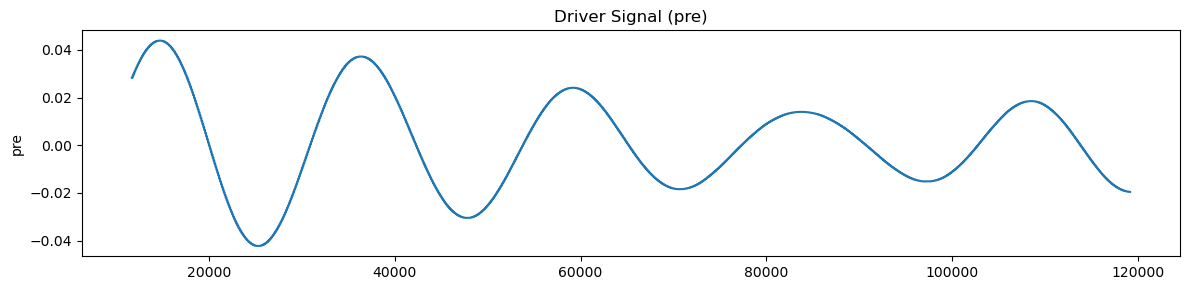

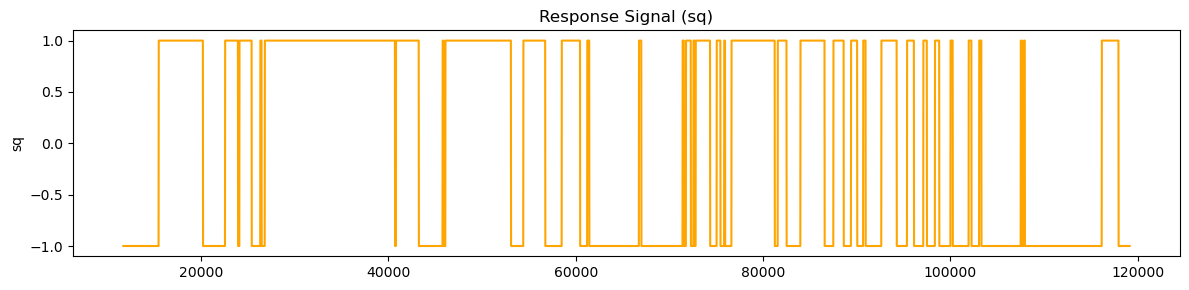

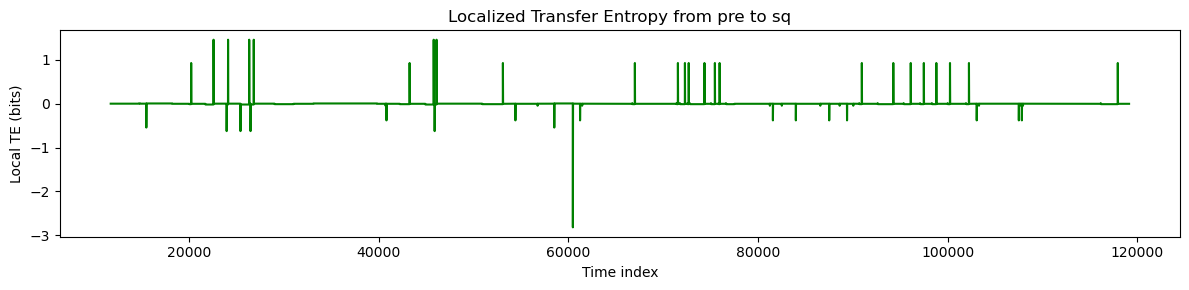

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pyinform import transfer_entropy

pre_ori = df_pre_i['pre'].values      # source (precession)
sq_ori = df_sq_i['sq'].values    # target (residual)

sq=sq_ori[::-1]
pre=pre_ori[::-1]

# --- 2) Discretization ---
# Pre: 4 bins
nbins_pre = 4
bins_pre = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc = np.digitize(pre, bins_pre) - 1

# SQ: binary mapping (-1 -> 0, +1 -> 1)
sq_disc = (sq > 0).astype(int)

# --- 3) Compute local transfer entropy using PyInform ---
# k=1 lag by default; local=True returns an array of pointwise TE values
local_te = transfer_entropy(pre_disc, sq_disc, k=1, local=True)

# --- 4) Plot the driver, response, and local TE ---
# t = np.arange(len(pre_disc))
t =df_pre_i['age'].values

plt.figure(figsize=(12, 3))
plt.plot(t, pre, label='pre (raw)')
plt.ylabel('pre')
plt.title('Driver Signal (pre)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(t, sq, label='sq (raw)', color='orange')
plt.ylabel('sq')
plt.title('Response Signal (sq)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 3))
plt.plot(t[1:], local_te.T, label='Local TE', color='green')
plt.xlabel('Time index')
plt.ylabel('Local TE (bits)')
plt.title('Localized Transfer Entropy from pre to sq')
plt.tight_layout()
plt.show()


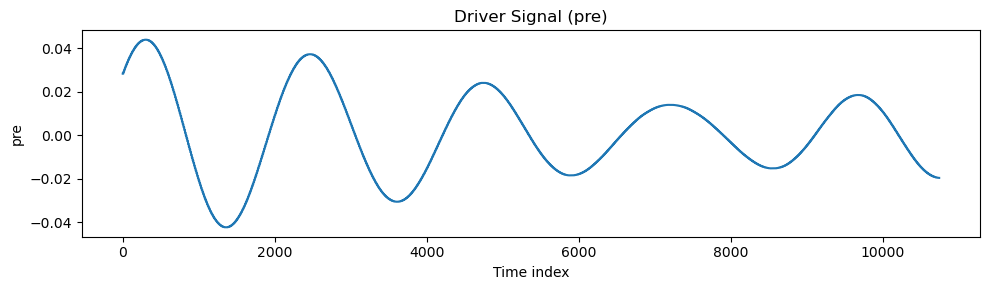

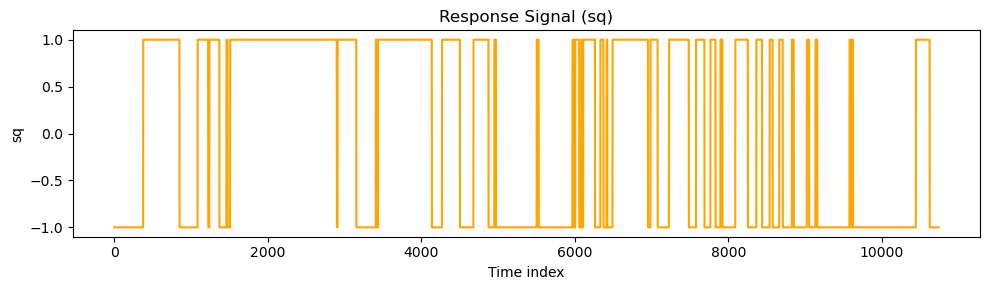

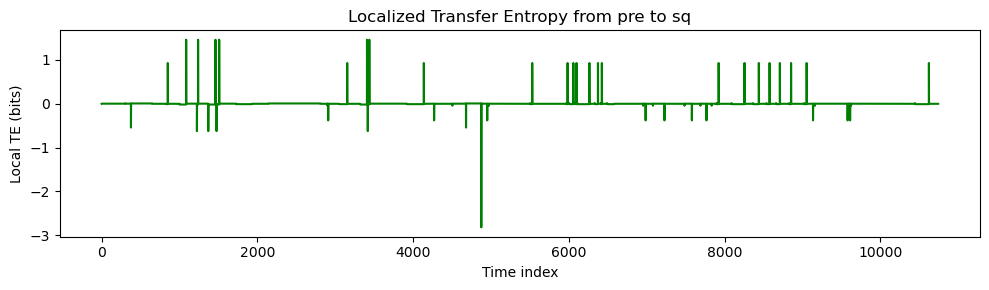

In [26]:
sq.shape
pre.shape

pre_ori = df_pre_i['pre'].values      # source (precession)
sq_ori = df_sq_i['sq'].values    # target (residual)

sq=sq_ori[::-1]
pre=pre_ori[::-1]


import numpy as np
import matplotlib.pyplot as plt
from collections import Counter


# --- 2) Discretization ---
# Pre: 4 bins
nbins_pre = 4
bins_pre = np.histogram_bin_edges(pre, bins=nbins_pre)
pre_disc = np.digitize(pre, bins_pre) - 1

# SQ: binary (2 bins) mapping -1->0, +1->1
sq_disc = (sq > 0).astype(int)

N = len(pre_disc)

# --- 3) Count frequencies for local TE ---
triplet_counts = Counter()
pair_counts = Counter()

for t in range(1, N):
    y_t    = sq_disc[t]
    y_prev = sq_disc[t - 1]
    x_prev = pre_disc[t - 1]
    triplet_counts[(y_t, y_prev, x_prev)] += 1
    pair_counts[(y_t, y_prev)] += 1

# Denominators for conditional probabilities
denom_triplet = {}
for (y_t, y_prev, x_prev), cnt in triplet_counts.items():
    denom_triplet[(y_prev, x_prev)] = denom_triplet.get((y_prev, x_prev), 0) + cnt

denom_pair = {}
for (y_t, y_prev), cnt in pair_counts.items():
    denom_pair[y_prev] = denom_pair.get(y_prev, 0) + cnt

# --- 4) Compute pointwise (local) transfer entropy ---
local_TE = np.zeros(N)
for t in range(1, N):
    y_t    = sq_disc[t]
    y_prev = sq_disc[t - 1]
    x_prev = pre_disc[t - 1]
    dj = denom_triplet.get((y_prev, x_prev), 0)
    dp = denom_pair.get(y_prev, 0)
    if dj > 0 and dp > 0:
        p_joint_cond = triplet_counts[(y_t, y_prev, x_prev)] / dj
        p_cond       = pair_counts[(y_t, y_prev)] / dp
        if p_cond > 0:
            local_TE[t] = np.log2(p_joint_cond / p_cond)

# --- 5) Plot the results ---
t = np.arange(N)

plt.figure(figsize=(10, 3))
plt.plot(t, pre, label='precession (raw)')
plt.xlabel('Time index')
plt.ylabel('pre')
plt.title('Driver Signal (pre)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, sq, label='sq (raw)', color='orange')
plt.xlabel('Time index')
plt.ylabel('sq')
plt.title('Response Signal (sq)')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 3))
plt.plot(t, local_TE, label='Local TE', color='green')
plt.xlabel('Time index')
plt.ylabel('Local TE (bits)')
plt.title('Localized Transfer Entropy from pre to sq')
plt.tight_layout()
plt.show()





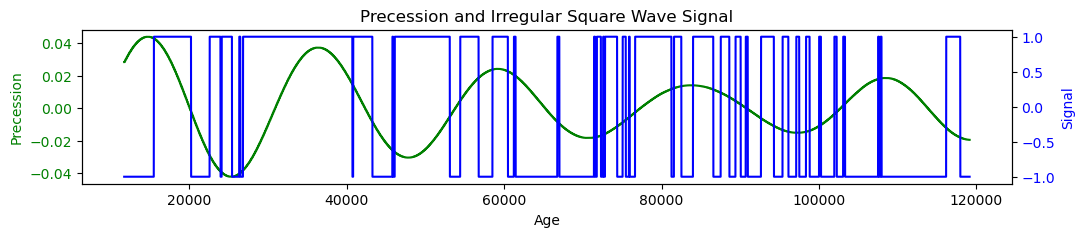

In [4]:
pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)

# flip the two signals upside down
pre = pre[::-1]
sq = sq[::-1]

# plot the two signals using twinx
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12, 2))
ax2 = ax1.twinx()
ax1.plot(df_pre_i['age'], pre, 'g-')
ax2.plot(df_sq_i['age'], sq, 'b-')
ax1.set_xlabel('Age')
ax1.set_ylabel('Precession', color='g')
ax2.set_ylabel('Signal', color='b')
ax1.tick_params(axis='y', labelcolor='g')
ax2.tick_params(axis='y', labelcolor='b')
plt.title("Precession and Irregular Square Wave Signal")
plt.show()


In [7]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) < 0  

# define low‐phase by taking the minimum level of your square wave
low_phase = sq.min()
low = (sq[1:] == low_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")


P(low | pre ↓) = 0.533
P(low | pre ↑) = 0.488
Chi² = 4.31,  p‐value = 0.037783152027146064


In [9]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) > 0  

# define low‐phase by taking the minimum level of your square wave
low_phase = sq.min()
low = (sq[1:] == low_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")

P(low | pre ↓) = 0.440
P(low | pre ↑) = 0.492
Chi² = 5.09,  p‐value = 0.024031994413653703


In [10]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) < 0  

# define low‐phase by taking the minimum level of your square wave
high_phase = sq.max()
low = (sq[1:] == high_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")

P(low | pre ↓) = 0.467
P(low | pre ↑) = 0.512
Chi² = 4.31,  p‐value = 0.037783152027146064


In [11]:
import numpy as np
from scipy.stats import chi2_contingency


slope_sign = np.diff(pre) > 0  

# define low‐phase by taking the minimum level of your square wave
high_phase = sq.max()
low = (sq[1:] == high_phase)  

# --- 2) build the 2×2 table of counts ---
#           low     not low
# slope↓   [ a ,       b  ]
# slope↑   [ c ,       d  ]
a = np.sum( slope_sign &  low)
b = np.sum( slope_sign & ~low)
c = np.sum(~slope_sign &  low)
d = np.sum(~slope_sign & ~low)

contingency = np.array([[a, b],
                        [c, d]])

# --- 3) conditional probabilities ---
p_low_given_down = a / (a + b)
p_low_given_up   = c / (c + d)

print(f"P(low | pre ↓) = {p_low_given_down:.3f}")
print(f"P(low | pre ↑) = {p_low_given_up:.3f}")

# --- 4) chi‐squared test of independence ---
chi2, p_value, dof, expected = chi2_contingency(contingency)

print(f"Chi² = {chi2:.2f},  p‐value = {p_value}")

P(low | pre ↓) = 0.560
P(low | pre ↑) = 0.508
Chi² = 5.09,  p‐value = 0.024031994413653703


In [5]:
sq.shape

(10744,)

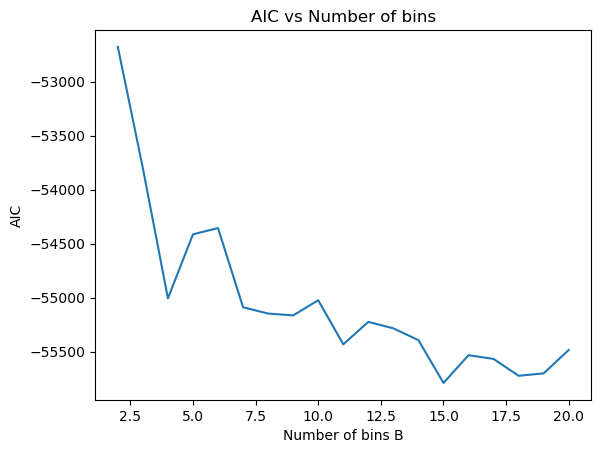

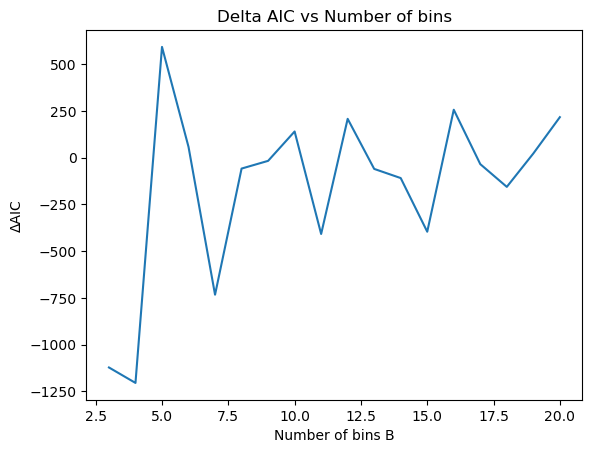

In [18]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

sa.plot_aic_delta(df_pre_i['pre'].values)

In [7]:
pre.shape

(1075,)

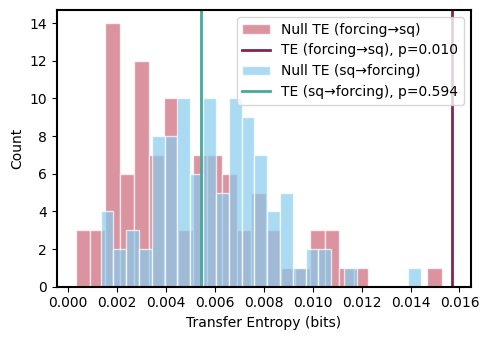

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=100, if_plot=False)

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq)
result
fig.savefig('TE_NGRIP.pdf',format='pdf',bbox_inches='tight')

# Change in smoothing length

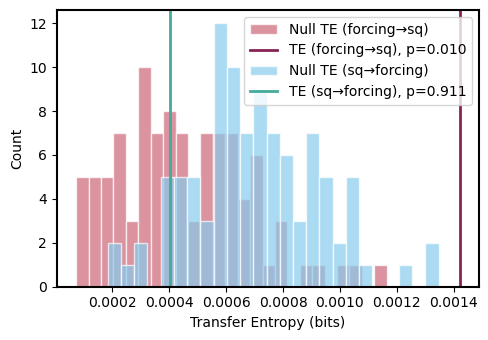

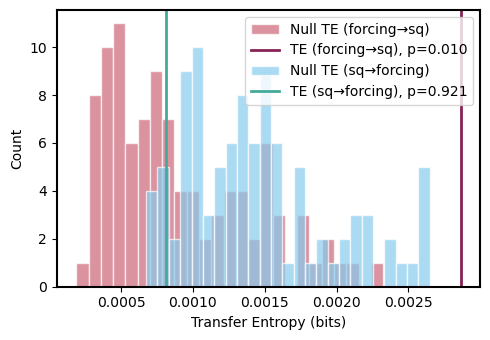

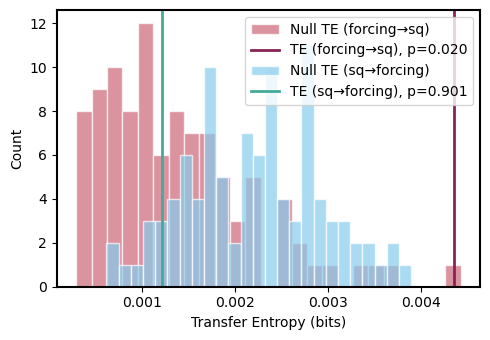

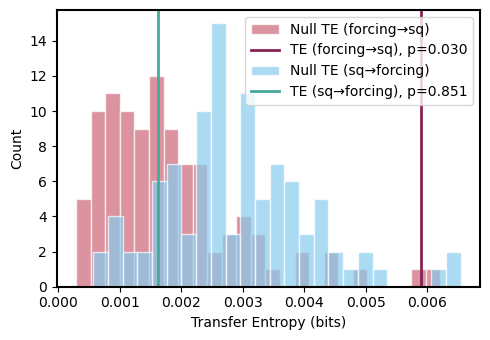

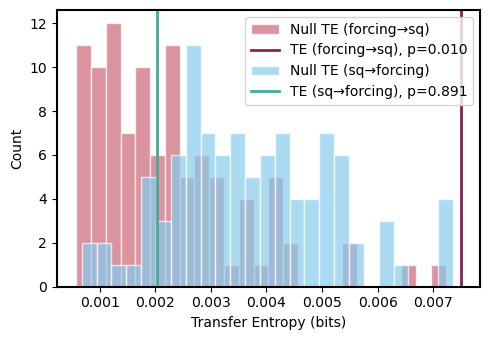

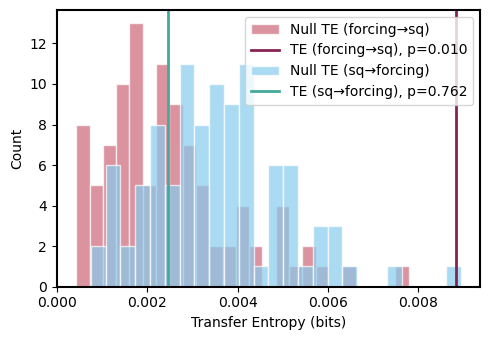

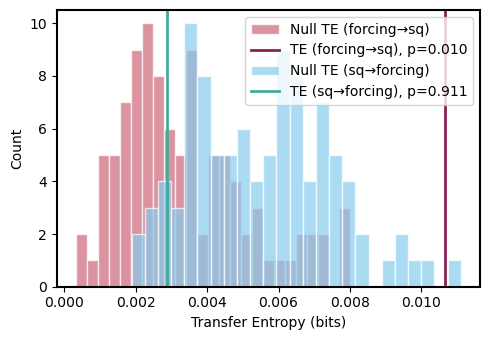

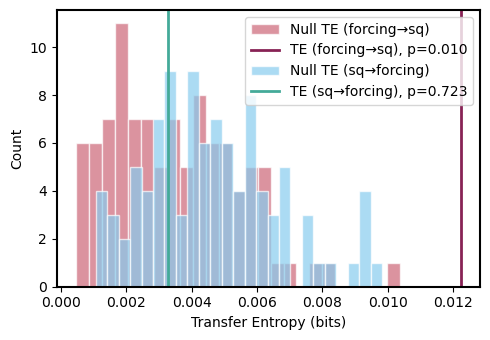

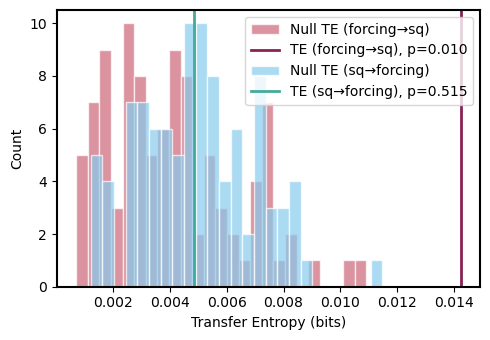

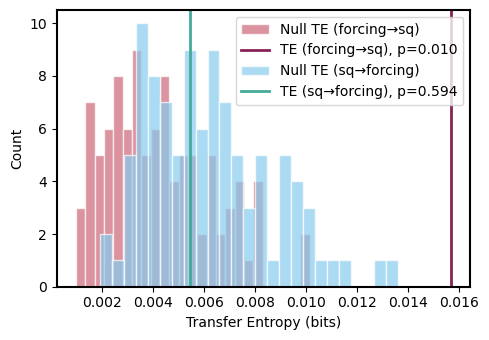

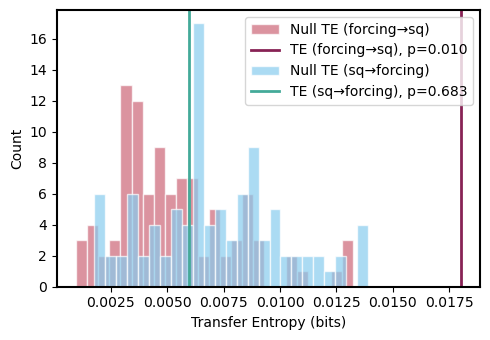

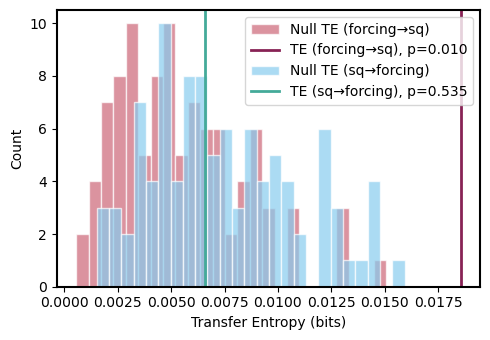

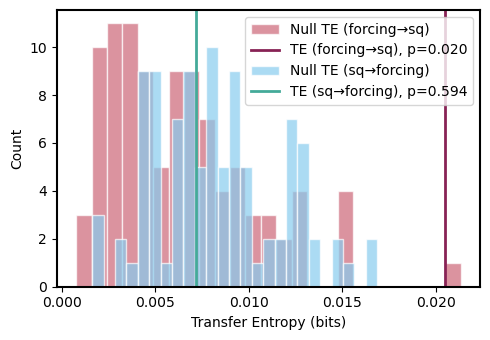

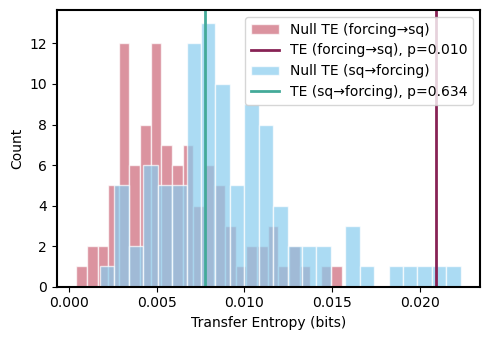

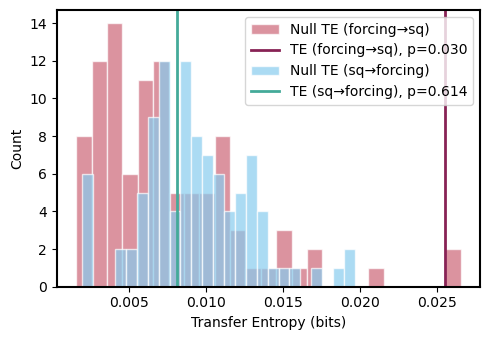

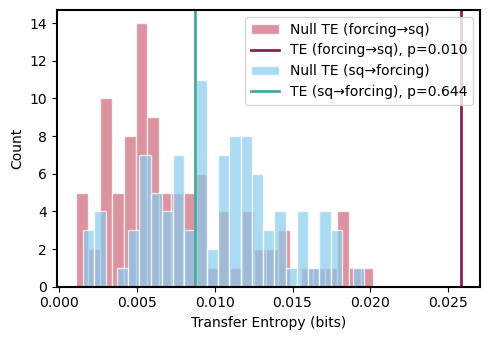

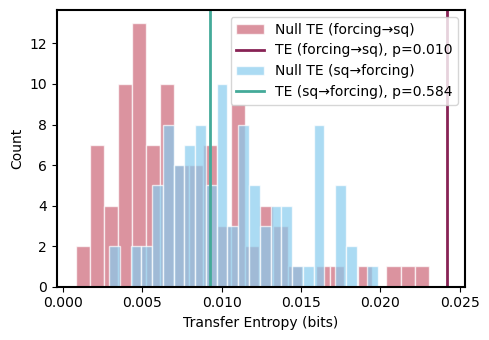

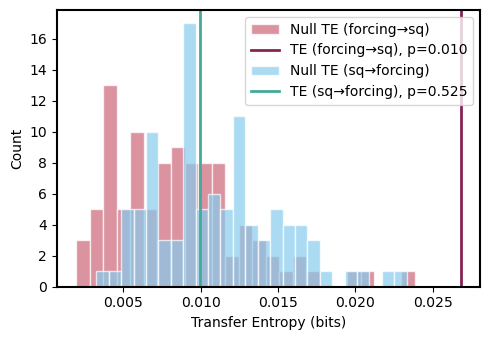

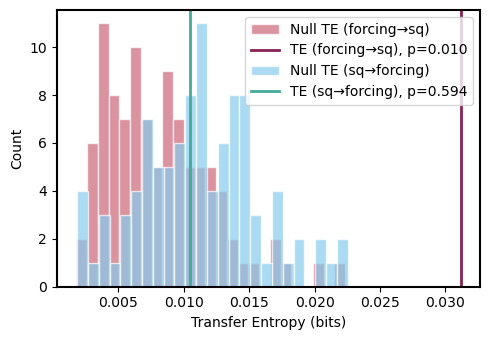

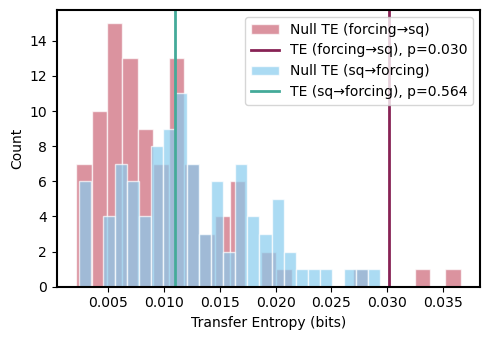

In [21]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

for interval in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]:
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=interval, if_plot=False)

    pre = df_pre_i['pre'].values      # source (precession)
    sq = df_sq_i['sq'].values    # target (residual)

    result,fig=sa.transfer_entropy_surrogate_test(pre,sq, k=1, forcing_bins=4)
    result
    # fig.savefig(f'TE_NGRIP_{interval}.pdf',format='pdf',bbox_inches='tight')



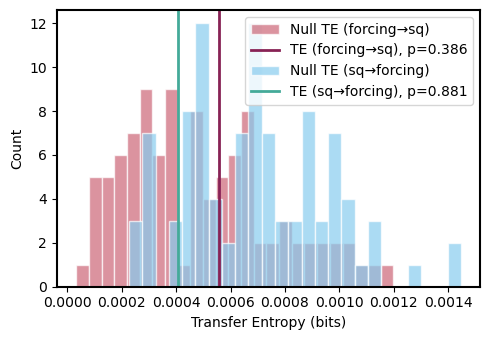

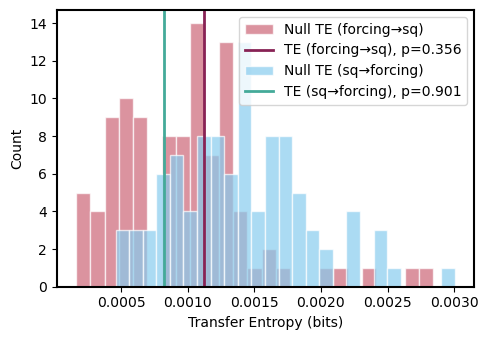

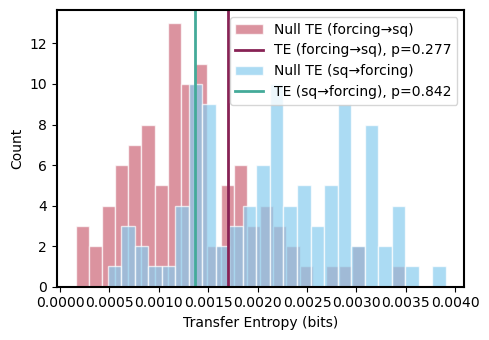

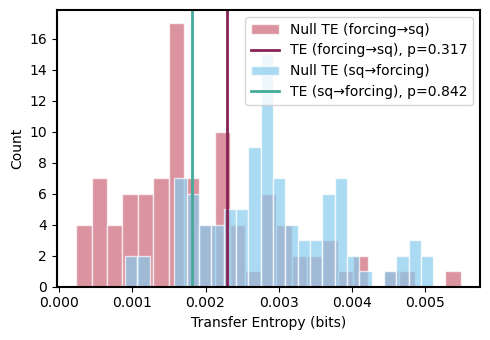

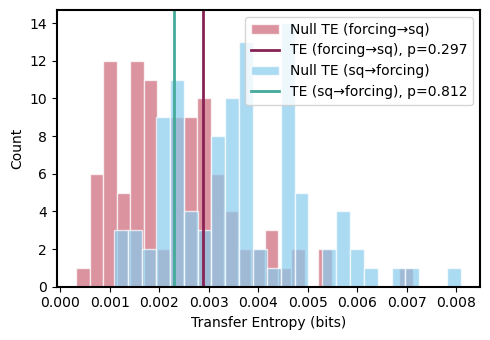

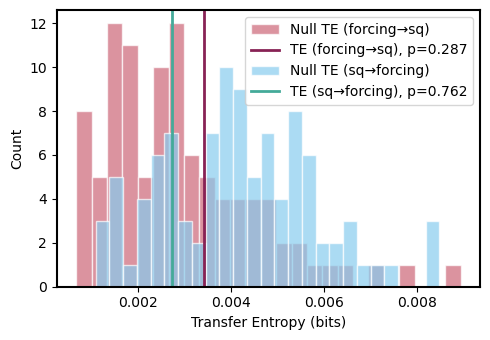

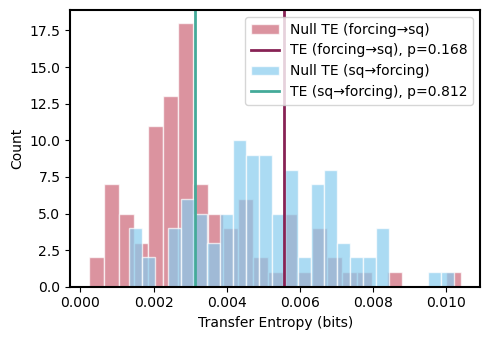

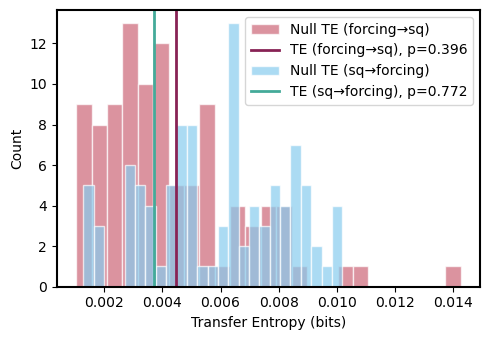

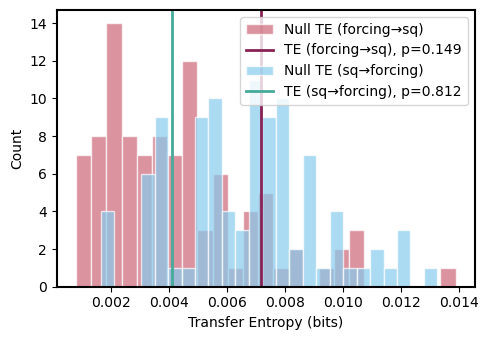

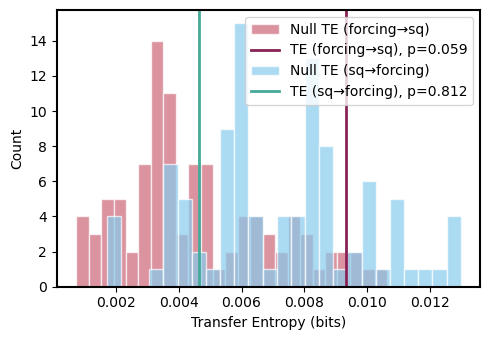

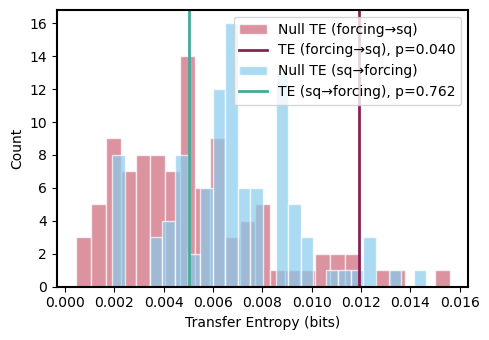

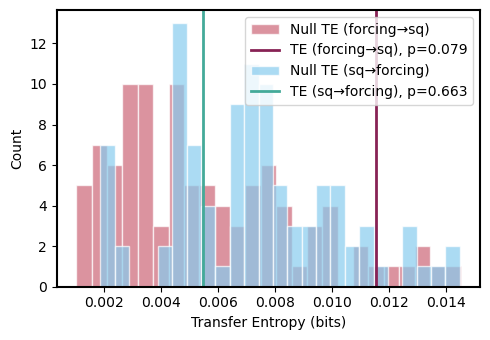

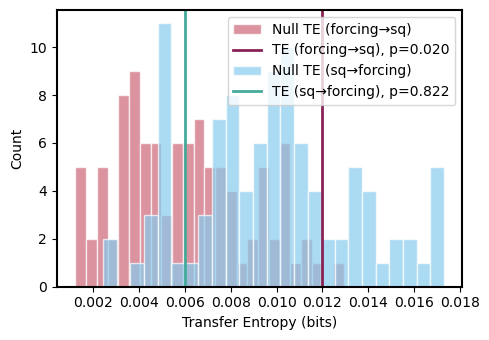

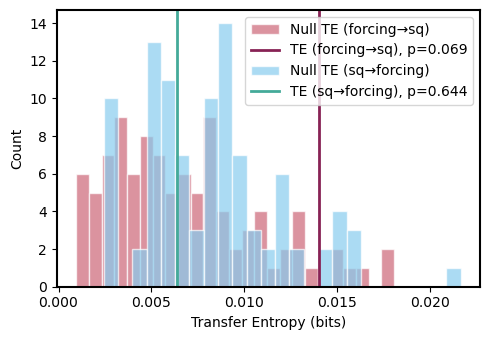

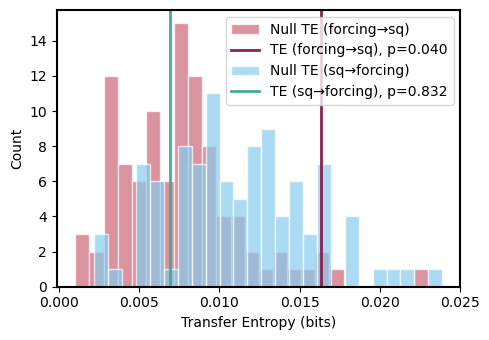

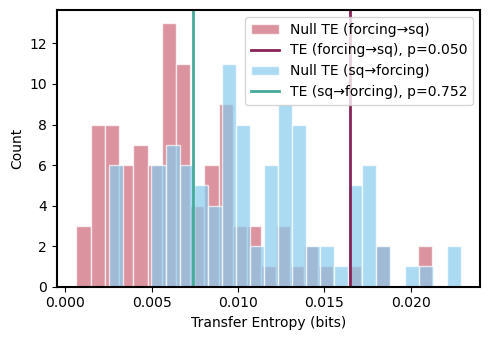

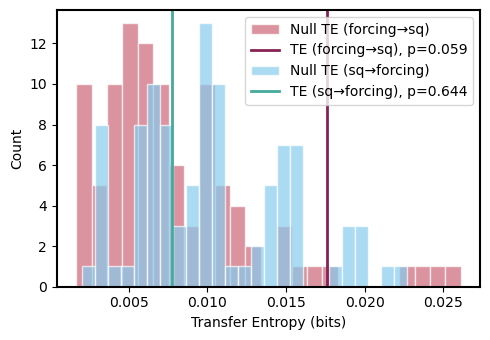

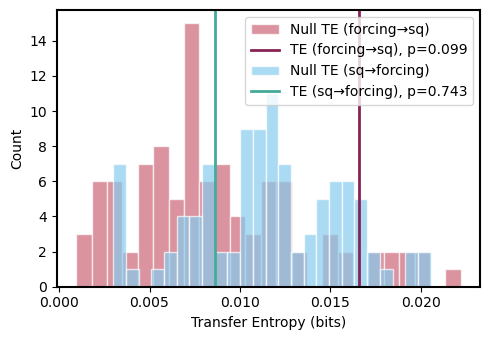

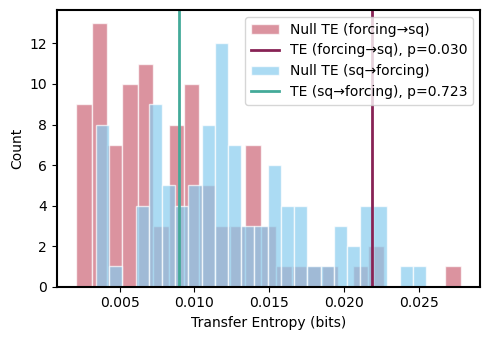

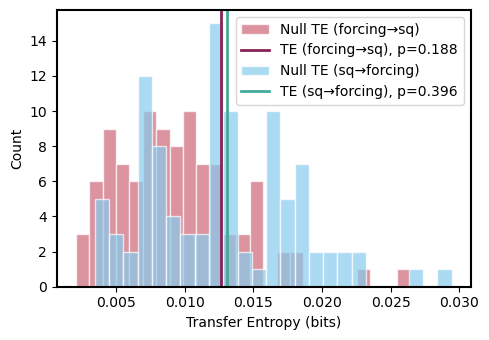

In [58]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

for interval in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150, 160, 170, 180, 190, 200]:
    df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=interval, if_plot=False)

    obl = df_obl_i['obl'].values      # source (precession)
    sq = df_sq_i['sq'].values    # target (residual)

    result,fig=sa.transfer_entropy_surrogate_test(obl,sq, k=1, forcing_bins=4)
    result

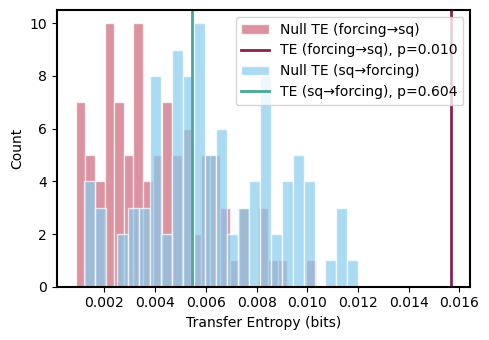

True

In [22]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq.copy(), interval=100, if_plot=False)

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, k=1, forcing_bins=4)
result

In [23]:
import numpy as np

for b in (3, 7):
    edges = np.histogram_bin_edges(pre, bins=b)
    counts, _ = np.histogram(pre, bins=edges)
    print(f"forcing_bins={b} → bin counts:", counts)


forcing_bins=3 → bin counts: [287 526 262]
forcing_bins=7 → bin counts: [ 67 119 251 192 257  97  92]


# Changes in interval and changes in bin number

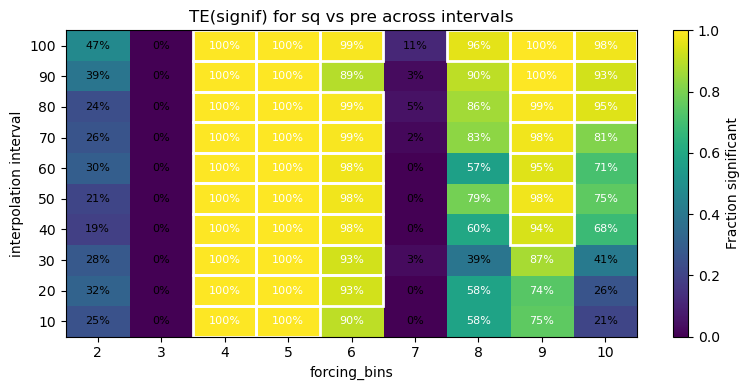

In [64]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

f=sa.mc_TE_heatmap_inter(
    df_sq,
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    forcing_var='pre',
    plot=True
)

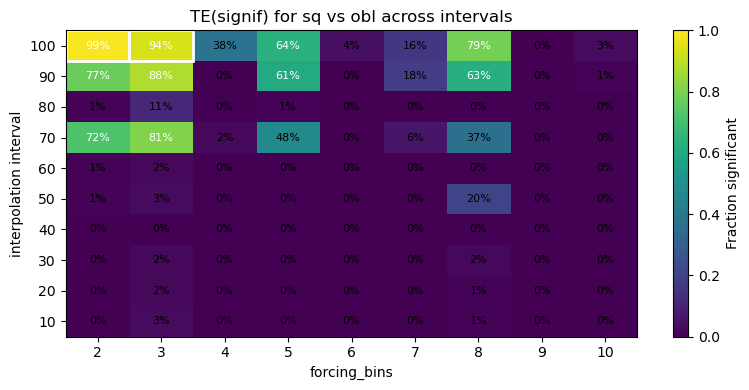

In [65]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

f=sa.mc_TE_heatmap_inter(
    df_sq,
    intervals=None,
    niter=100,
    n_surr=100,
    alpha=0.05,
    k=1,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    forcing_var='obl',
    plot=True
)

# Changes in lag and bin numbers

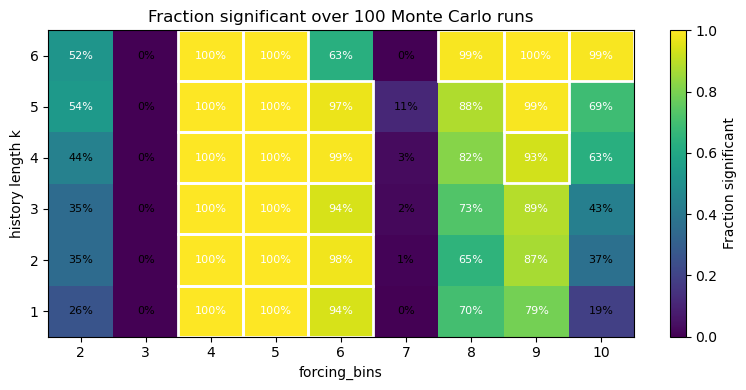

In [66]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fractions= sa.mc_TE_heatmap(
    pre =df_pre_i['pre'].values,
    sq =df_sq_i['sq'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    plot=True)

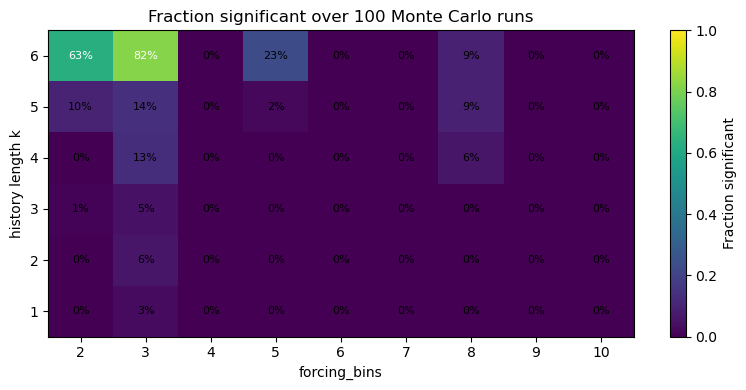

In [67]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)


fractions= sa.mc_TE_heatmap(
    pre =df_obl_i['obl'].values,
    sq =df_sq_i['sq'].values,
    niter=100,
    n_surr=100,
    alpha=0.05,
    ks=None,
    gbins=None,
    p_thresh=0.9,
    n_jobs=-1,
    if_plot=False,
    plot=True)





MC iters: 100%|██████████| 100/100 [00:16<00:00,  6.15it/s]


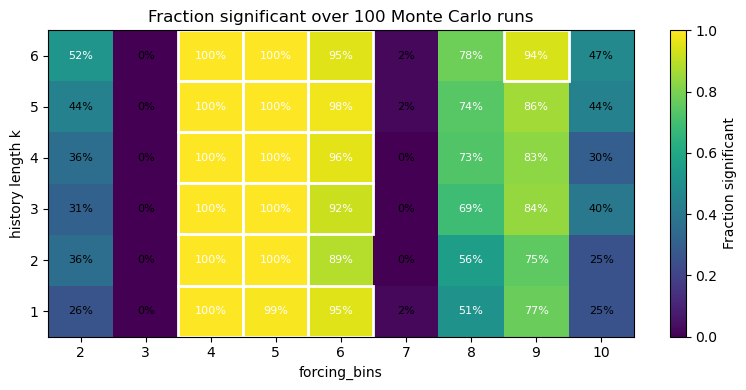

In [6]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)



import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib
from joblib import Parallel, delayed
from tqdm import tqdm

# reload in case you tweak the TE function
importlib.reload(sa)

# ── 0) SETTINGS ───────────────────────────────────────────────────────────────
N_JOBS   = -1         # use all cores
niter    = 100        # Monte Carlo reps
n_surr   = 100        # surrogates per TE test
alpha    = 0.05       # p-value threshold
p_thresh = 0.9        # for boxing in the plot

ks    = [1,2,3,4,5,6]  # history lengths
gbins = list(range(2,11))   # 2…10

# ── 1) PREPARE THE DATA ──────────────────────────────────────────────────────
df_sq_i, df_pre_i, _ = sa.interpolate_data_forcing(
    df_sq.copy(),
    interval=10,
    if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# ── 2) WORKER for one Monte Carlo iteration ─────────────────────────────────
def one_mc_iter(pre, sq, ks, gbins, n_surr, alpha):
    """
    Perform *one* randomization sweep over all (k,forcing_bins) pairs,
    returning a (len(ks),len(gbins)) matrix of 0/1 significance flags.
    """
    local_counts = np.zeros((len(ks), len(gbins)), dtype=int)
    for i, k in enumerate(ks):
        for j, b in enumerate(gbins):
            sig, _ = sa.transfer_entropy_surrogate_test(
                pre, sq,
                k=k,
                forcing_bins=b,
                n_surr=n_surr,
                p=alpha,
                if_plot=False
            )
            local_counts[i,j] = int(sig)
    return local_counts

# ── 3) LAUNCH niter WORKERS IN PARALLEL ────────────────────────────────────
# Each returns a counts‐matrix; we'll sum them all.
results = Parallel(n_jobs=N_JOBS, backend="loky")(
    delayed(one_mc_iter)(pre, sq, ks, gbins, n_surr, alpha)
    for _ in tqdm(range(niter), desc="MC iters")
)

# stack & sum across Monte Carlo reps
total_counts = np.stack(results, axis=0).sum(axis=0)

# fraction significant at each (k,b)
fractions = total_counts / niter

# ── 4) PLOT THE HEATMAP WITH WHITE BOXES & ANNOTATIONS ────────────────────
fig, ax = plt.subplots(figsize=(8,4))

im = ax.imshow(
    fractions,
    origin='lower',
    aspect='auto',
    cmap='viridis',
    vmin=0, vmax=1
)

# axes ticks
ax.set_xticks(np.arange(len(gbins)))
ax.set_xticklabels(gbins)
ax.set_xlabel('forcing_bins')

ax.set_yticks(np.arange(len(ks)))
ax.set_yticklabels(ks)
ax.set_ylabel('history length k')

ax.set_title(f'Fraction significant over {niter} Monte Carlo runs')

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Fraction significant')

# white boxes where fraction > p_thresh
for i, j in zip(*np.where(fractions > p_thresh)):
    rect = plt.Rectangle(
        (j - 0.5, i - 0.5),
        1, 1,
        fill=False,
        edgecolor='white',
        linewidth=2
    )
    ax.add_patch(rect)

# annotate each cell with percentage
for i in range(len(ks)):
    for j in range(len(gbins)):
        pct = fractions[i,j] * 100
        color = 'white' if fractions[i,j] > 0.5 else 'black'
        ax.text(j, i, f"{pct:.0f}%", ha='center', va='center',
                color=color, fontsize=8)

plt.tight_layout()
plt.show()



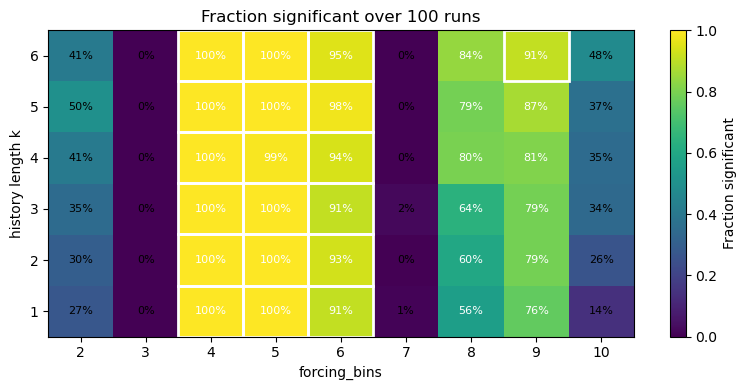

In [70]:
import numpy as np
import matplotlib.pyplot as plt
from toolbox import sq_ana as sa
import importlib

# reload in case you tweak the function
importlib.reload(sa)

# --- 0) settings ---
niter   = 100           # Monte Carlo repetitions
p_thresh = 0.9          # fraction threshold for boxing

# --- 1) prepare your fixed time series once ---
df_sq_i, df_pre_i, _ = sa.interpolate_data_forcing(
    df_sq.copy(),
    interval=10,
    if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# --- 2) define the parameter grid ---
ks     = [1, 2, 3, 4, 5, 6]
gbins  = list(range(2, 11))   # 2 through 8 inclusive

# matrix to accumulate counts of "significant" outcomes
counts = np.zeros((len(ks), len(gbins)), dtype=int)

# --- 3) Monte Carlo loop ---
for it in range(niter):
    for i, k in enumerate(ks):
        for j, b in enumerate(gbins):
            sig, _ = sa.transfer_entropy_surrogate_test(
                pre, sq,
                k=k,
                forcing_bins=b,
                # leave sq_bins at its default of 2
                n_surr=100,
                p=0.05,
                if_plot=False
            )
            counts[i, j] += int(sig)

# compute the fraction of runs significant
fractions = counts / niter


# --- 4) plot the 2D heatmap of fractions ---
fig, ax = plt.subplots(figsize=(8, 4))

im = ax.imshow(
    fractions,
    origin='lower',        # so k=1 is bottom row
    aspect='auto',
    cmap='viridis',
    vmin=0, vmax=1
)

# ticks & labels
ax.set_xticks(np.arange(len(gbins)))
ax.set_xticklabels(gbins)
ax.set_xlabel('forcing_bins')

ax.set_yticks(np.arange(len(ks)))
ax.set_yticklabels(ks)
ax.set_ylabel('history length k')

ax.set_title(f'Fraction significant over {niter} runs')

# colorbar
cbar = fig.colorbar(im, ax=ax)
cbar.set_label('Fraction significant')

# --- outline cells where fraction > p_thresh with white box ---
for i, j in zip(*np.where(fractions > p_thresh)):
    rect = plt.Rectangle(
        (j-0.5, i-0.5),   # (x, y) corner
        width=1, height=1,
        fill=False,
        edgecolor='white',
        linewidth=2
    )
    ax.add_patch(rect)

# --- annotate every cell with percentage ---
for i in range(len(ks)):
    for j in range(len(gbins)):
        pct = fractions[i, j] * 100
        # choose text color for contrast
        txt_color = 'white' if fractions[i, j] > 0.5 else 'black'
        ax.text(
            j, i, f"{pct:.0f}%",
            ha='center', va='center',
            color=txt_color,
            fontsize=8
        )

plt.tight_layout()
plt.show()




# Influence of temporal uncertainty

In [26]:
import numpy as np
from toolbox import sq_ana as sa
import importlib

# reload in case sq_ana changed
importlib.reload(sa)

# your existing preprocessing
max_age_error = 3000
max_age_ratio = max_age_error / np.max(df_sq['age'].values)

df_sq_stretch = df_sq.copy()
df_sq_stretch['age'] = df_sq_stretch['age'].values * max_age_ratio

# single interpolation (we'll reuse these series each iteration)
df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(
    df_sq_stretch.copy(), 10, if_plot=False
)
pre = df_pre_i['pre'].values
sq  = df_sq_i['sq'].values

# now run n_iter repeats of the TE test
n_iter = 100
count_true = 0

for _ in range(n_iter):
    result, _ = sa.transfer_entropy_surrogate_test(
        pre, sq,
        forcing_bins=4,
        if_plot=False
    )
    if result:
        count_true += 1

percent_true = count_true / n_iter * 100
print(f"Result was True in {count_true}/{n_iter} runs ({percent_true:.1f}%)")


Result was True in 96/100 runs (96.0%)


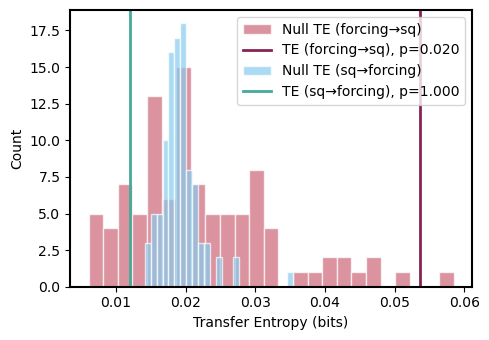

True

In [ ]:
from toolbox import sq_ana as sa 
import importlib
importlib.reload(sa)

max_age_error =3000
max_age_ratio = max_age_error/np.max(df_sq['age'].values)

df_sq_stretch = df_sq.copy()
df_sq_stretch['age'] = df_sq_stretch['age'].values * max_age_ratio

df_sq_i, df_pre_i, df_obl_i = sa.interpolate_data_forcing(df_sq_stretch.copy(), 10, if_plot=False)


pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)


result,fig=sa.transfer_entropy_surrogate_test(pre,sq, forcing_bins=4, if_plot=False)


result

In [10]:
np.max(df_sq['age'].values)

119139

# Time varying entropy

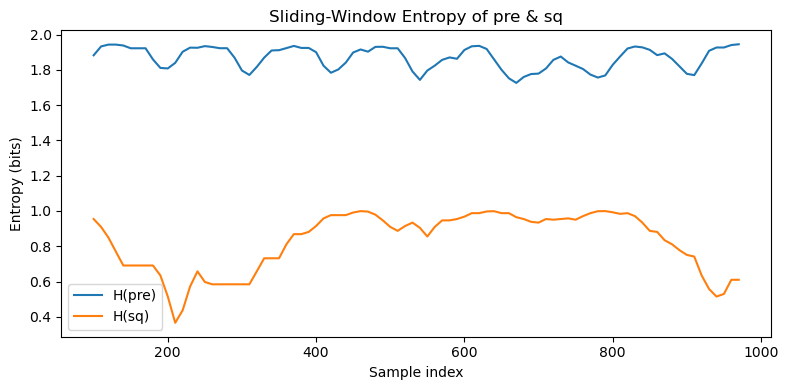

Full-data Transfer Entropy X→Y = 0.014947 bits


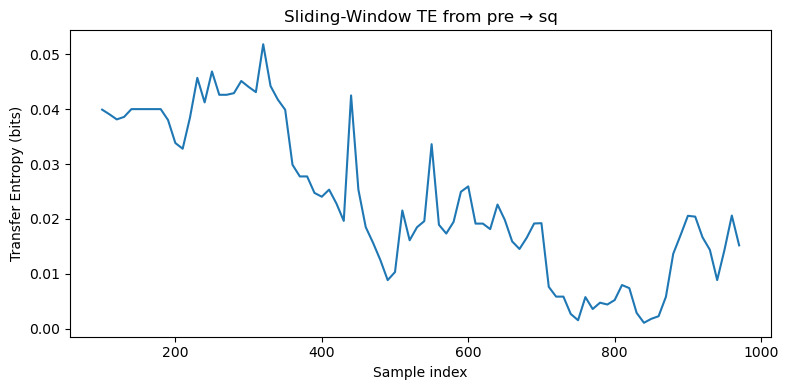

In [ ]:




import numpy as np
import matplotlib.pyplot as plt

pre = df_pre_i['pre'].values      # source (precession)
sq = df_sq_i['sq'].values    # target (residual)
# flip data upside down
pre = pre [::-1]
sq  = sq  [::-1]

# Parameters
window_size = 200           # samples ≃ one period
step_size   = 10            # slide by 10 samples
nbins_pre   = 4            # for entropy of pre
nbins_TE    = 4             # discretization for transfer-entropy
T           = len(pre)

# Time-axis (just sample index or convert to seconds if you know fs)
times = np.arange(T)

# 1) Sliding-window entropy for pre and sq
ent_pre = []
ent_sq  = []
ent_times = []

for start in range(0, T - window_size + 1, step_size):
    w_pre = pre[start:start+window_size]
    w_sq  = sq [start:start+window_size]

    # Shannon entropy of pre (20‐bin histogram)
    counts, _ = np.histogram(w_pre, bins=nbins_pre)
    p = counts / counts.sum()
    p = p[p>0]
    H_pre = -np.sum(p * np.log2(p))

    # Shannon entropy of sq (2‐bin: low vs high)
    counts, _ = np.histogram(w_sq, bins=2)
    p = counts / counts.sum()
    p = p[p>0]
    H_sq = -np.sum(p * np.log2(p))

    ent_pre.append(H_pre)
    ent_sq .append(H_sq)
    ent_times.append(start + window_size//2)

# Plot both entropies on one figure
plt.figure(figsize=(8,4))
plt.plot(ent_times, ent_pre, label='H(pre)')
plt.plot(ent_times, ent_sq,  label='H(sq)')
plt.xlabel('Sample index')
plt.ylabel('Entropy (bits)')
plt.title('Sliding-Window Entropy of pre & sq')
plt.legend()
plt.tight_layout()
plt.show()


# 2) Define a function to compute TE(X→Y) on discretized sequences
def transfer_entropy(x_disc, y_disc, nbins):
    # TE = ∑ p(yₜ₊₁,yₜ,xₜ) · log₂[ p(yₜ₊₁|yₜ,xₜ) / p(yₜ₊₁|yₜ) ]
    T = len(y_disc) - 1
    c_xyz = np.zeros((2,2,nbins))   # yₜ₊₁ ∈ {0,1}, yₜ ∈ {0,1}, xₜ ∈ [0..nbins-1]
    c_yx  = np.zeros((2,nbins))
    c_yy  = np.zeros((2,2))
    c_y   = np.zeros(2)

    for t0 in range(T):
        y1 = y_disc[t0+1]
        y0 = y_disc[t0]
        x0 = x_disc[t0]
        c_xyz[y1,y0,x0] += 1
        c_yx [y0,  x0]   += 1
        c_yy [y1, y0]    += 1
        c_y  [y0]        += 1

    p_xyz = c_xyz / T
    p_yx  = c_yx  / T
    p_yy  = c_yy  / T
    p_y   = c_y   / T

    TE = 0.0
    for y1 in (0,1):
        for y0 in (0,1):
            for x0 in range(nbins):
                pj = p_xyz[y1,y0,x0]
                if pj > 0 and p_yx[y0,x0] > 0 and p_yy[y1,y0] > 0 and p_y[y0] > 0:
                    p1 = pj / p_yx[y0,x0]      # p(yₜ₊₁|yₜ,xₜ)
                    p2 = p_yy[y1,y0] / p_y[y0]  # p(yₜ₊₁|yₜ)
                    TE += pj * np.log2(p1 / p2)
    return TE

# Discretize full sequences
#  - pre → x_disc in [0..nbins_TE-1]
#  - sq  → y_disc ∈ {0,1}
edges = np.linspace(np.min(pre), np.max(pre), nbins_TE+1)
x_full = np.digitize(pre, bins=edges[1:-1])
y_full = (sq > 0).astype(int)

TE_full = transfer_entropy(x_full, y_full, nbins_TE)
print(f"Full-data Transfer Entropy X→Y = {TE_full:.6f} bits")


# 3) Time-varying TE via sliding windows
TE_slide = []
TE_times = []

for start in range(0, T - window_size + 1, step_size):
    xw = x_full[start:start+window_size]
    yw = y_full[start:start+window_size]
    TEw = transfer_entropy(xw, yw, nbins_TE)
    TE_slide.append(TEw)
    TE_times.append(start + window_size//2)

# Plot time-varying TE
plt.figure(figsize=(8,4))
plt.plot(TE_times, TE_slide)
plt.xlabel('Sample index')
plt.ylabel('Transfer Entropy (bits)')
plt.title('Sliding-Window TE from pre → sq')
plt.tight_layout()
plt.show()
